In [ ]:
# --- Colab & GPU setup ----------------------------------------------------

try:
    import google.colab
    !pip install -qU spacy scipy shap xgboost accelerate
    !python -m spacy download en_core_web_sm
except ModuleNotFoundError:
    pass

import torch
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device
print(f"Running on device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Running on device: cpu


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
print("📊 Loading train_ablation.csv...")
df = pd.read_csv('train_ablation.csv')
print(f"✅ Dataset loaded: {df.shape}")
print(f"📋 Columns: {list(df.columns)}")

# Check class distribution
print(f"\n🎯 Original class distribution:")
class_counts = df['binary_label_code'].value_counts()
print(f"Human (0): {class_counts[0]:,}")
print(f"AI (1): {class_counts[1]:,}")

# Add text length for sampling strategy
df['text_length'] = df['generation'].str.len()
print(f"\n📏 Text length statistics:")
print(f"Mean: {df['text_length'].mean():.0f} chars")
print(f"Median: {df['text_length'].median():.0f} chars")
print(f"Min: {df['text_length'].min():.0f} chars")
print(f"Max: {df['text_length'].max():.0f} chars")

# Stratified sampling with preference for longer texts
print(f"\n🎲 Creating balanced 4000-sample subset...")

# Sample 2000 from each class
human_df = df[df['binary_label_code'] == 0].copy()
ai_df = df[df['binary_label_code'] == 1].copy()

# Sort by text length (descending) and take top 80% to prefer longer texts
def sample_with_length_preference(class_df, n_samples=2000, length_percentile=80):
    # Get length threshold (prefer texts above this length)
    length_threshold = class_df['text_length'].quantile((100-length_percentile)/100)

    # Separate into preferred (longer) and remaining texts
    preferred = class_df[class_df['text_length'] >= length_threshold]
    remaining = class_df[class_df['text_length'] < length_threshold]

    print(f"   Preferred pool: {len(preferred):,} texts (≥{length_threshold:.0f} chars)")
    print(f"   Remaining pool: {len(remaining):,} texts")

    # Sample more from preferred texts
    n_from_preferred = min(int(n_samples * 0.7), len(preferred))  # 70% from longer texts
    n_from_remaining = n_samples - n_from_preferred

    if n_from_remaining > len(remaining):
        n_from_remaining = len(remaining)
        n_from_preferred = n_samples - n_from_remaining

    sampled_preferred = preferred.sample(n=n_from_preferred, random_state=42)
    sampled_remaining = remaining.sample(n=n_from_remaining, random_state=42)

    return pd.concat([sampled_preferred, sampled_remaining])

print(f"\n👥 Sampling Human texts:")
human_sample = sample_with_length_preference(human_df, n_samples=2000)

print(f"\n🤖 Sampling AI texts:")
ai_sample = sample_with_length_preference(ai_df, n_samples=2000)

# Combine samples
df_subset = pd.concat([human_sample, ai_sample]).reset_index(drop=True)

# Shuffle the combined dataset
df_subset = df_subset.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ SUBSET CREATED:")
print(f"📊 Final subset shape: {df_subset.shape}")
print(f"🎯 Class distribution:")
subset_counts = df_subset['binary_label_code'].value_counts()
print(f"   Human (0): {subset_counts[0]:,}")
print(f"   AI (1): {subset_counts[1]:,}")

print(f"\n📏 Text length comparison:")
print(f"Original dataset - Mean: {df['text_length'].mean():.0f}, Median: {df['text_length'].median():.0f}")
print(f"Subset dataset   - Mean: {df_subset['text_length'].mean():.0f}, Median: {df_subset['text_length'].median():.0f}")

# Show length distribution
print(f"\n📈 Length percentiles in subset:")
for p in [25, 50, 75, 90, 95]:
    print(f"   {p}th percentile: {df_subset['text_length'].quantile(p/100):.0f} chars")

# Clean up
df_subset = df_subset.drop('text_length', axis=1)

print(f"\n🎉 Ready for co-reference feature extraction!")
print(f"💾 Use 'df_subset' for next steps ({len(df_subset):,} texts)")

📊 Loading train_ablation.csv...
✅ Dataset loaded: (16000, 18)
📋 Columns: ['gpt2_perplexity', 'type_token_ratio', 'repeated_3gram_ratio', 'unique_2grams', 'unique_3grams', 'sentence_length_std', 'sentence_length_entropy', 'pos_transition_entropy', 'punctuation_ratio', 'avg_word_length', 'flesch_reading_ease', 'pos_ratio_X', 'binary_label', 'binary_label_code', 'generation', 'id', 'adv_source_id', 'source_id']

🎯 Original class distribution:
Human (0): 8,000
AI (1): 8,000

📏 Text length statistics:
Mean: 1678 chars
Median: 1400 chars
Min: 29 chars
Max: 47555 chars

🎲 Creating balanced 4000-sample subset...

👥 Sampling Human texts:
   Preferred pool: 6,402 texts (≥1041 chars)
   Remaining pool: 1,598 texts

🤖 Sampling AI texts:
   Preferred pool: 6,403 texts (≥776 chars)
   Remaining pool: 1,597 texts

✅ SUBSET CREATED:
📊 Final subset shape: (4000, 19)
🎯 Class distribution:
   Human (0): 2,000
   AI (1): 2,000

📏 Text length comparison:
Original dataset - Mean: 1678, Median: 1400
Subset d

In [ ]:
# Advanced Multi-Strategy Heuristic Coreference Extractor
import pandas as pd
import numpy as np
import re
import spacy
import math
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Set, Optional
from tqdm import tqdm
import string

class AdvancedHeuristicCorefExtractor:
    def __init__(self):
        self.feature_names = [
            'chain_diversity_entropy',
            'chain_length_variance',
            'long_range_coref_ratio',
            'mention_complexity',
            'singleton_ratio',
            'pronoun_ratio',
            'chain_connectivity',
            'avg_cluster_size'
        ]

        print("🔧 Initializing Advanced Multi-Strategy Heuristic Coreference Extractor...")

        # Load spaCy model
        try:
            self.nlp = spacy.load("en_core_web_sm")
            print("✅ spaCy model loaded")
        except OSError:
            print("📦 Installing spaCy model...")
            import subprocess, sys
            subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])
            self.nlp = spacy.load("en_core_web_sm")
            print("✅ spaCy model installed and loaded")

        # Optimize pipeline
        self.nlp.disable_pipes(['lemmatizer'])

        # Enhanced pronoun classification with gender/number
        self.pronoun_info = {
            # Personal pronouns with gender/number info
            'i': {'type': 'personal_subject', 'person': 1, 'number': 'singular', 'gender': None},
            'me': {'type': 'personal_object', 'person': 1, 'number': 'singular', 'gender': None},
            'my': {'type': 'possessive', 'person': 1, 'number': 'singular', 'gender': None},
            'mine': {'type': 'possessive', 'person': 1, 'number': 'singular', 'gender': None},
            'myself': {'type': 'reflexive', 'person': 1, 'number': 'singular', 'gender': None},

            'you': {'type': 'personal', 'person': 2, 'number': 'both', 'gender': None},
            'your': {'type': 'possessive', 'person': 2, 'number': 'both', 'gender': None},
            'yours': {'type': 'possessive', 'person': 2, 'number': 'both', 'gender': None},
            'yourself': {'type': 'reflexive', 'person': 2, 'number': 'singular', 'gender': None},
            'yourselves': {'type': 'reflexive', 'person': 2, 'number': 'plural', 'gender': None},

            'he': {'type': 'personal_subject', 'person': 3, 'number': 'singular', 'gender': 'masculine'},
            'him': {'type': 'personal_object', 'person': 3, 'number': 'singular', 'gender': 'masculine'},
            'his': {'type': 'possessive', 'person': 3, 'number': 'singular', 'gender': 'masculine'},
            'himself': {'type': 'reflexive', 'person': 3, 'number': 'singular', 'gender': 'masculine'},

            'she': {'type': 'personal_subject', 'person': 3, 'number': 'singular', 'gender': 'feminine'},
            'her': {'type': 'personal_object', 'person': 3, 'number': 'singular', 'gender': 'feminine'},
            'hers': {'type': 'possessive', 'person': 3, 'number': 'singular', 'gender': 'feminine'},
            'herself': {'type': 'reflexive', 'person': 3, 'number': 'singular', 'gender': 'feminine'},

            'it': {'type': 'personal', 'person': 3, 'number': 'singular', 'gender': 'neuter'},
            'its': {'type': 'possessive', 'person': 3, 'number': 'singular', 'gender': 'neuter'},
            'itself': {'type': 'reflexive', 'person': 3, 'number': 'singular', 'gender': 'neuter'},

            'we': {'type': 'personal_subject', 'person': 1, 'number': 'plural', 'gender': None},
            'us': {'type': 'personal_object', 'person': 1, 'number': 'plural', 'gender': None},
            'our': {'type': 'possessive', 'person': 1, 'number': 'plural', 'gender': None},
            'ours': {'type': 'possessive', 'person': 1, 'number': 'plural', 'gender': None},
            'ourselves': {'type': 'reflexive', 'person': 1, 'number': 'plural', 'gender': None},

            'they': {'type': 'personal_subject', 'person': 3, 'number': 'plural', 'gender': None},
            'them': {'type': 'personal_object', 'person': 3, 'number': 'plural', 'gender': None},
            'their': {'type': 'possessive', 'person': 3, 'number': 'plural', 'gender': None},
            'theirs': {'type': 'possessive', 'person': 3, 'number': 'plural', 'gender': None},
            'themselves': {'type': 'reflexive', 'person': 3, 'number': 'plural', 'gender': None},

            # Demonstratives
            'this': {'type': 'demonstrative', 'distance': 'near', 'number': 'singular'},
            'that': {'type': 'demonstrative', 'distance': 'far', 'number': 'singular'},
            'these': {'type': 'demonstrative', 'distance': 'near', 'number': 'plural'},
            'those': {'type': 'demonstrative', 'distance': 'far', 'number': 'plural'},
        }

        self.all_pronouns = set(self.pronoun_info.keys())

        # Entity type patterns for better matching
        self.entity_patterns = {
            'person': [
                r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\b',  # Proper names
                r'\b(?:Mr|Mrs|Ms|Dr|Prof|President|CEO|Director)\.?\s[A-Z][a-z]+\b',  # Titles
            ],
            'organization': [
                r'\b[A-Z][a-z]*(?:\s[A-Z][a-z]*)*\s(?:Inc|Corp|Ltd|LLC|Company|Corporation|Group|Institute|University|College)\b',
                r'\b(?:The\s)?[A-Z][a-z]*(?:\s[A-Z][a-z]*)*\s(?:Foundation|Association|Society|Organization)\b',
            ],
            'location': [
                r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)*\s(?:City|State|Country|County|Province|Region)\b',
                r'\b(?:New|North|South|East|West)\s[A-Z][a-z]+\b',
            ]
        }

        # Compile patterns
        self.compiled_patterns = {}
        for category, patterns in self.entity_patterns.items():
            self.compiled_patterns[category] = [re.compile(p) for p in patterns]

        print("✅ Advanced heuristic coreference extractor ready!")
        print(f"   Using: Multi-strategy heuristic approach")
        print(f"   Strategies: Entity matching, pronoun resolution, syntactic analysis, semantic similarity")
        print(f"   Pronouns: {len(self.all_pronouns)} with detailed linguistic features")

    def _extract_enhanced_mentions(self, text: str, doc) -> List[Dict]:
        """Extract mentions using multiple strategies"""
        mentions = []

        # Strategy 1: spaCy NER entities
        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE', 'PRODUCT', 'EVENT', 'FAC', 'NORP']:
                mentions.append({
                    'text': ent.text,
                    'start_token': ent.start,
                    'end_token': ent.end,
                    'start_char': ent.start_char,
                    'end_char': ent.end_char,
                    'type': 'entity',
                    'subtype': ent.label_,
                    'sent_idx': self._get_sent_idx(doc, ent.start),
                    'head_token': ent.root.i,
                    'canonical': self._normalize_entity(ent.text),
                    'entity_type': self._classify_entity_type(ent.text, ent.label_)
                })

        # Strategy 2: Pattern-based entity detection
        for category, patterns in self.compiled_patterns.items():
            for pattern in patterns:
                for match in pattern.finditer(text):
                    start_char = match.start()
                    end_char = match.end()
                    matched_text = match.group()

                    # Convert to token positions
                    start_token = None
                    end_token = None
                    for token in doc:
                        if token.idx <= start_char < token.idx + len(token.text):
                            start_token = token.i
                        if token.idx < end_char <= token.idx + len(token.text):
                            end_token = token.i + 1
                            break

                    if start_token is not None and end_token is not None:
                        # Check if not already covered by NER
                        if not any(m['start_char'] <= start_char < m['end_char'] for m in mentions):
                            mentions.append({
                                'text': matched_text,
                                'start_token': start_token,
                                'end_token': end_token,
                                'start_char': start_char,
                                'end_char': end_char,
                                'type': 'entity',
                                'subtype': category.upper(),
                                'sent_idx': self._get_sent_idx(doc, start_token),
                                'head_token': start_token,
                                'canonical': self._normalize_entity(matched_text),
                                'entity_type': category
                            })

        # Strategy 3: Pronoun detection with features
        for token in doc:
            if token.text.lower() in self.all_pronouns:
                pronoun_info = self.pronoun_info[token.text.lower()]
                mentions.append({
                    'text': token.text,
                    'start_token': token.i,
                    'end_token': token.i + 1,
                    'start_char': token.idx,
                    'end_char': token.idx + len(token.text),
                    'type': 'pronoun',
                    'subtype': pronoun_info['type'],
                    'sent_idx': self._get_sent_idx(doc, token.i),
                    'head_token': token.i,
                    'pronoun_features': pronoun_info
                })

        # Strategy 4: Definite descriptions
        for token in doc:
            if token.text.lower() in ['the', 'this', 'that', 'these', 'those']:
                # Look for noun phrase
                noun_phrase_tokens = []
                current_token = token

                # Skip the determiner and collect the noun phrase
                for next_token in doc[token.i + 1:min(token.i + 5, len(doc))]:
                    if next_token.pos_ in ['NOUN', 'PROPN', 'ADJ']:
                        noun_phrase_tokens.append(next_token)
                    elif next_token.pos_ in ['ADP', 'CONJ']:  # Stop at prepositions/conjunctions
                        break
                    elif len(noun_phrase_tokens) > 0:  # Stop if we have some nouns and hit something else
                        break

                if noun_phrase_tokens and noun_phrase_tokens[-1].pos_ in ['NOUN', 'PROPN']:
                    phrase_text = token.text + ' ' + ' '.join([t.text for t in noun_phrase_tokens])
                    mentions.append({
                        'text': phrase_text,
                        'start_token': token.i,
                        'end_token': noun_phrase_tokens[-1].i + 1,
                        'start_char': token.idx,
                        'end_char': noun_phrase_tokens[-1].idx + len(noun_phrase_tokens[-1].text),
                        'type': 'definite',
                        'subtype': token.text.lower(),
                        'sent_idx': self._get_sent_idx(doc, token.i),
                        'head_token': noun_phrase_tokens[-1].i,
                        'canonical': self._normalize_entity(' '.join([t.text for t in noun_phrase_tokens]))
                    })

        return mentions

    def _normalize_entity(self, text: str) -> str:
        """Normalize entity text for better matching"""
        # Remove punctuation and extra spaces
        normalized = re.sub(r'[^\w\s]', '', text.lower().strip())
        # Handle common abbreviations
        normalized = re.sub(r'\binc\b', 'incorporated', normalized)
        normalized = re.sub(r'\bcorp\b', 'corporation', normalized)
        normalized = re.sub(r'\bltd\b', 'limited', normalized)
        normalized = re.sub(r'\bco\b', 'company', normalized)
        return normalized

    def _classify_entity_type(self, text: str, ner_label: str) -> str:
        """Classify entity type for better matching"""
        if ner_label == 'PERSON':
            return 'person'
        elif ner_label in ['ORG', 'NORP']:
            return 'organization'
        elif ner_label in ['GPE', 'FAC']:
            return 'location'
        else:
            return 'other'

    def _create_advanced_coreference_chains(self, mentions: List[Dict], doc) -> List[List[Dict]]:
        """Create coreference chains using advanced heuristics"""
        chains = []
        used_mentions = set()

        # Strategy 1: Exact and fuzzy entity matching
        entity_mentions = [m for m in mentions if m['type'] == 'entity']
        entity_groups = defaultdict(list)

        for mention in entity_mentions:
            canonical = mention['canonical']
            entity_groups[canonical].append(mention)

            # Also check for partial matches (abbreviations, etc.)
            for other_mention in entity_mentions:
                if mention != other_mention and id(mention) not in used_mentions and id(other_mention) not in used_mentions:
                    if self._are_same_entity(mention, other_mention):
                        entity_groups[canonical].append(other_mention)

        # Create chains from entity groups
        for group in entity_groups.values():
            unique_mentions = []
            seen_ids = set()
            for mention in group:
                if id(mention) not in seen_ids:
                    unique_mentions.append(mention)
                    seen_ids.add(id(mention))

            if len(unique_mentions) > 1:
                chains.append(unique_mentions)
                for mention in unique_mentions:
                    used_mentions.add(id(mention))

        # Strategy 2: Link pronouns to entities with advanced compatibility
        pronouns = [m for m in mentions if m['type'] == 'pronoun' and id(m) not in used_mentions]
        entities = [m for m in mentions if m['type'] == 'entity' and id(m) not in used_mentions]

        for pronoun in pronouns:
            best_antecedent = None
            best_score = 0

            for entity in entities:
                if id(entity) in used_mentions:
                    continue

                score = self._calculate_pronoun_entity_score(pronoun, entity, doc)
                if score > best_score and score > 0.5:  # Threshold for matching
                    best_antecedent = entity
                    best_score = score

            if best_antecedent:
                # Check if entity is already in a chain
                entity_chain = None
                for chain in chains:
                    if best_antecedent in chain:
                        entity_chain = chain
                        break

                if entity_chain:
                    entity_chain.append(pronoun)
                else:
                    chains.append([best_antecedent, pronoun])

                used_mentions.add(id(pronoun))
                used_mentions.add(id(best_antecedent))

        # Strategy 3: Link definite descriptions
        definite_mentions = [m for m in mentions if m['type'] == 'definite' and id(m) not in used_mentions]

        for def_mention in definite_mentions:
            best_match = None
            best_score = 0

            # Look for entities with similar head nouns
            for entity in entities:
                if id(entity) in used_mentions:
                    continue

                similarity = self._calculate_semantic_similarity(def_mention, entity)
                if similarity > best_score and similarity > 0.3:
                    best_match = entity
                    best_score = similarity

            if best_match:
                # Add to existing chain or create new one
                entity_chain = None
                for chain in chains:
                    if best_match in chain:
                        entity_chain = chain
                        break

                if entity_chain:
                    entity_chain.append(def_mention)
                else:
                    chains.append([best_match, def_mention])

                used_mentions.add(id(def_mention))

        # Strategy 4: Pronoun-pronoun linking (same gender/number)
        remaining_pronouns = [m for m in mentions if m['type'] == 'pronoun' and id(m) not in used_mentions]

        pronoun_groups = defaultdict(list)
        for pronoun in remaining_pronouns:
            features = pronoun.get('pronoun_features', {})
            key = (features.get('gender'), features.get('number'), features.get('person'))
            pronoun_groups[key].append(pronoun)

        for group in pronoun_groups.values():
            if len(group) >= 2:
                # Only link if they're reasonably close
                group.sort(key=lambda x: x['sent_idx'])
                valid_group = [group[0]]

                for i in range(1, len(group)):
                    if group[i]['sent_idx'] - valid_group[-1]['sent_idx'] <= 3:  # Within 3 sentences
                        valid_group.append(group[i])

                if len(valid_group) >= 2:
                    chains.append(valid_group)
                    for mention in valid_group:
                        used_mentions.add(id(mention))

        return chains

    def _are_same_entity(self, mention1: Dict, mention2: Dict) -> bool:
        """Check if two mentions refer to the same entity"""
        text1 = mention1['canonical']
        text2 = mention2['canonical']

        # Exact match
        if text1 == text2:
            return True

        # One is substring of the other (abbreviation case)
        if len(text1) >= 3 and len(text2) >= 3:
            if text1 in text2 or text2 in text1:
                return True

        # Same entity type and significant overlap
        if mention1.get('entity_type') == mention2.get('entity_type'):
            words1 = set(text1.split())
            words2 = set(text2.split())

            if len(words1.intersection(words2)) / min(len(words1), len(words2)) > 0.5:
                return True

        return False

    def _calculate_pronoun_entity_score(self, pronoun: Dict, entity: Dict, doc) -> float:
        """Calculate compatibility score between pronoun and entity"""
        score = 0.0

        # Distance penalty (closer is better)
        distance = abs(pronoun['sent_idx'] - entity['sent_idx'])
        if distance == 0:
            score += 0.5  # Same sentence
        elif distance == 1:
            score += 0.3  # Adjacent sentences
        elif distance <= 3:
            score += 0.1  # Within 3 sentences
        else:
            return 0.0  # Too far

        # Gender agreement
        pronoun_features = pronoun.get('pronoun_features', {})
        entity_type = entity.get('entity_type', 'other')

        pronoun_gender = pronoun_features.get('gender')
        if pronoun_gender == 'masculine' and entity_type == 'person':
            score += 0.3
        elif pronoun_gender == 'feminine' and entity_type == 'person':
            score += 0.3
        elif pronoun_gender == 'neuter' and entity_type in ['organization', 'location', 'other']:
            score += 0.3
        elif pronoun_gender is None:  # 'they', 'we', etc.
            score += 0.1

        # Number agreement (basic)
        pronoun_number = pronoun_features.get('number')
        if pronoun_number == 'plural':
            if entity.get('subtype') in ['ORG', 'NORP'] or 'companies' in entity['text'].lower():
                score += 0.2
        else:
            score += 0.1

        # Syntactic role compatibility
        if pronoun_features.get('type') in ['personal_subject', 'personal_object']:
            score += 0.2

        return min(score, 1.0)

    def _calculate_semantic_similarity(self, mention1: Dict, mention2: Dict) -> float:
        """Calculate semantic similarity between mentions"""
        if mention1['type'] == 'definite' and mention2['type'] == 'entity':
            # Extract head noun from definite description
            def_canonical = mention1.get('canonical', '')
            entity_canonical = mention2.get('canonical', '')

            # Simple word overlap
            words1 = set(def_canonical.split())
            words2 = set(entity_canonical.split())

            if words1 and words2:
                overlap = len(words1.intersection(words2))
                return overlap / min(len(words1), len(words2))

        return 0.0

    def _get_sent_idx(self, doc, token_idx: int) -> int:
        """Get sentence index for a token"""
        for sent_idx, sent in enumerate(doc.sents):
            if sent.start <= token_idx < sent.end:
                return sent_idx
        return 0

    def _calculate_enhanced_features(self, chains: List[List[Dict]], all_mentions: List[Dict], text: str) -> Dict[str, float]:
        """Calculate all 8 coreference features with enhanced precision"""
        features = {name: 0.0 for name in self.feature_names}

        if not all_mentions:
            return features

        try:
            # Add singleton chains for calculation
            chained_mention_ids = set()
            for chain in chains:
                for mention in chain:
                    chained_mention_ids.add(id(mention))

            singleton_mentions = [m for m in all_mentions if id(m) not in chained_mention_ids]
            all_chains = chains + [[mention] for mention in singleton_mentions]

            # Calculate text statistics
            doc_tokens = len(text.split())
            doc_sentences = max(mention['sent_idx'] for mention in all_mentions) + 1 if all_mentions else 1
            total_mention_tokens = sum(len(mention['text'].split()) for mention in all_mentions)

            # 1. Chain Diversity Entropy
            chain_entropies = []
            for chain in chains:
                if len(chain) <= 1:
                    continue

                type_counts = Counter(mention['type'] for mention in chain)
                total = len(chain)
                entropy = 0.0

                for count in type_counts.values():
                    if count > 0:
                        p = count / total
                        entropy -= p * math.log2(p)

                chain_entropies.append(entropy)

            features['chain_diversity_entropy'] = np.mean(chain_entropies) if chain_entropies else 0.0

            # 2. Chain Length Variance
            chain_lengths = [len(chain) for chain in all_chains]
            features['chain_length_variance'] = np.var(chain_lengths) if len(chain_lengths) > 1 else 0.0

            # 3. Long-range Coreference Ratio
            long_range_count = 0
            multi_mention_chains = [chain for chain in chains if len(chain) > 1]

            for chain in multi_mention_chains:
                sent_positions = [mention['sent_idx'] for mention in chain]
                span = max(sent_positions) - min(sent_positions)
                if span >= 2:
                    long_range_count += 1

            features['long_range_coref_ratio'] = long_range_count / len(multi_mention_chains) if multi_mention_chains else 0.0

            # 4. Mention Complexity
            features['mention_complexity'] = total_mention_tokens / len(all_mentions) if all_mentions else 0.0

            # 5. Singleton Ratio
            features['singleton_ratio'] = len(singleton_mentions) / len(all_chains) if all_chains else 0.0

            # 6. Pronoun Ratio
            pronoun_count = sum(1 for mention in all_mentions if mention['type'] == 'pronoun')
            features['pronoun_ratio'] = pronoun_count / len(all_mentions) if all_mentions else 0.0

            # 7. Chain Connectivity
            connectivity_scores = []
            for chain in multi_mention_chains:
                positions = [mention['start_token'] for mention in chain]
                span = max(positions) - min(positions)
                coverage = span / max(doc_tokens, 1)
                density = len(chain) / max(span, 1) if span > 0 else len(chain)
                connectivity = coverage * math.log1p(density)
                connectivity_scores.append(connectivity)

            features['chain_connectivity'] = np.mean(connectivity_scores) if connectivity_scores else 0.0

            # 8. Average Cluster Size
            multi_mention_sizes = [len(chain) for chain in multi_mention_chains]
            features['avg_cluster_size'] = np.mean(multi_mention_sizes) if multi_mention_sizes else 0.0

        except Exception as e:
            print(f"⚠️ Error calculating features: {e}")

        return features

    def extract_features(self, text: str) -> Dict[str, float]:
        """Extract coreference features using advanced heuristics"""
        features = {name: 0.0 for name in self.feature_names}

        if not text or len(text.strip()) < 10:
            return features

        try:
            # Process text
            doc = self.nlp(text[:2000])  # Increased limit for better analysis

            # Extract mentions using multiple strategies
            mentions = self._extract_enhanced_mentions(text, doc)

            # Create coreference chains
            chains = self._create_advanced_coreference_chains(mentions, doc)

            # Calculate features
            if mentions:
                features = self._calculate_enhanced_features(chains, mentions, text)

        except Exception as e:
            print(f"⚠️ Error in feature extraction: {e}")

        return features

    def extract_coref_features(self, df: pd.DataFrame, text_column: str = 'generation') -> pd.DataFrame:
        """Extract coreference features for entire dataframe"""
        print(f"🔍 Advanced Heuristic extracting co-reference features from {len(df)} texts...")
        print(f"Method: Multi-Strategy Advanced Heuristic Coreference Resolution")

        df_result = df.copy()
        for feature_name in self.feature_names:
            df_result[feature_name] = 0.0

        successful_extractions = 0
        failed_extractions = 0

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Advanced Processing"):
            try:
                text = row[text_column]
                if pd.isna(text) or len(str(text).strip()) < 10:
                    failed_extractions += 1
                    continue

                text_str = str(text)
                features = self.extract_features(text_str)

                for feature_name, value in features.items():
                    if np.isfinite(value):
                        df_result.at[idx, feature_name] = value

                if any(value > 0 for value in features.values()):
                    successful_extractions += 1
                else:
                    failed_extractions += 1

            except Exception as e:
                failed_extractions += 1
                continue

        print(f"✅ Advanced extraction complete: {successful_extractions}/{len(df)} successful")

        if failed_extractions > 0:
            print(f"⚠️  Failed extractions: {failed_extractions}")

        # Feature statistics
        print(f"\n📊 Advanced Feature Statistics:")
        for feature_name in self.feature_names:
            values = df_result[feature_name]
            non_zero = (values > 0).sum()
            mean_val = values.mean()
            std_val = values.std()
            print(f"{feature_name}: μ={mean_val:.4f}, σ={std_val:.4f}, non-zero={non_zero}/{len(df)} ({100*non_zero/len(df):.1f}%)")

        return df_result

    def test_extractor(self):
        """Test the advanced extractor with sample texts"""
        print("\n🧪 TESTING ADVANCED MULTI-STRATEGY HEURISTIC EXTRACTOR")
        print("=" * 70)

        test_texts = [
            "John went to the store. He bought some milk. The milk was fresh and John liked it very much.",
            "Apple Inc. announced its new product. The company said it will be available next month. Apple is excited about this launch.",
            "Mary called her friend Sarah. She wanted to invite her to the party. Sarah was happy to accept the invitation.",
            "The researchers published their findings. They found significant results. The study took two years to complete.",
            "Dr. Smith met with his colleague Dr. Johnson. He discussed the research project with her. The project involves machine learning.",
            "The cat sat on the mat. It was a comfortable spot. The animal seemed very content there.",
            "Microsoft Corporation released their quarterly report. The tech giant performed well. This performance exceeded expectations."
        ]

        working_tests = 0

        for i, text in enumerate(test_texts, 1):
            print(f"\n🔍 Advanced Test {i}:")
            print(f"Text: {text}")

            try:
                doc = self.nlp(text)
                mentions = self._extract_enhanced_mentions(text, doc)
                chains = self._create_advanced_coreference_chains(mentions, doc)

                if chains:
                    print(f"🔗 Detected {len(chains)} coreference chains:")
                    for j, chain in enumerate(chains):
                        mention_texts = [f"{m['text']}({m['type']})" for m in chain]
                        print(f"   Chain {j+1}: {' → '.join(mention_texts)}")

                isolated = [m for m in mentions if not any(m in chain for chain in chains)]
                if isolated:
                    print(f"🔸 {len(isolated)} isolated mentions: {[m['text'] for m in isolated[:5]]}")

                features = self.extract_features(text)
                non_zero_features = {k: v for k, v in features.items() if v > 0}

                if non_zero_features:
                    print(f"✅ Advanced features extracted:")
                    for fname, fval in non_zero_features.items():
                        print(f"   {fname}: {fval:.4f}")
                    working_tests += 1
                else:
                    print(f"⚠️  No coreference features detected")

            except Exception as e:
                print(f"❌ Error in test {i}: {e}")

        print(f"\n📊 Advanced Test Results: {working_tests}/{len(test_texts)} tests successful")
        return working_tests > 0

# Initialize the advanced extractor
print("🚀 Initializing Advanced Multi-Strategy Heuristic Coreference Extractor...")

try:
    extractor = AdvancedHeuristicCorefExtractor()

    print("\n🧪 Running comprehensive advanced test...")
    test_success = extractor.test_extractor()

    if test_success:
        print("\n✅ Advanced heuristic coreference extractor working successfully!")
        print("🎯 Advanced Strategies Used:")
        print("   • Multi-pattern entity recognition (NER + regex patterns)")
        print("   • Gender/number-aware pronoun resolution")
        print("   • Fuzzy entity matching (abbreviations, partial matches)")
        print("   • Definite description linking")
        print("   • Syntactic role compatibility")
        print("   • Distance-based scoring")
        print("   • Semantic similarity matching")
        print("📝 Usage: df_with_features = extractor.extract_coref_features(df)")
    else:
        print("\n⚠️  Some tests failed, but extractor may still work on real data")

    print(f"\n🎯 Advanced Features extracted:")
    for i, feature in enumerate(extractor.feature_names, 1):
        print(f"   {i}. {feature}")

    globals()['extractor'] = extractor

except Exception as e:
    print(f"❌ Failed to initialize advanced extractor: {e}")
    print("💡 Make sure spaCy is installed: pip install spacy && python -m spacy download en_core_web_sm")

🚀 Initializing Advanced Multi-Strategy Heuristic Coreference Extractor...
🔧 Initializing Advanced Multi-Strategy Heuristic Coreference Extractor...
✅ spaCy model loaded
✅ Advanced heuristic coreference extractor ready!
   Using: Multi-strategy heuristic approach
   Strategies: Entity matching, pronoun resolution, syntactic analysis, semantic similarity
   Pronouns: 35 with detailed linguistic features

🧪 Running comprehensive advanced test...

🧪 TESTING ADVANCED MULTI-STRATEGY HEURISTIC EXTRACTOR

🔍 Advanced Test 1:
Text: John went to the store. He bought some milk. The milk was fresh and John liked it very much.
🔗 Detected 3 coreference chains:
   Chain 1: John(entity) → John(entity)
   Chain 2: He(entity) → He(pronoun)
   Chain 3: The(entity) → it(pronoun)
🔸 2 isolated mentions: ['the store', 'The milk']
✅ Advanced features extracted:
   chain_diversity_entropy: 0.6667
   chain_length_variance: 0.2400
   long_range_coref_ratio: 0.3333
   mention_complexity: 1.2500
   singleton_ratio:

🧬 CO-REFERENCE RESOLUTION FEATURE ANALYSIS
📊 Loading dataset...
✅ Dataset loaded: (4000, 18)

🔍 Extracting co-reference features...
🔍 Advanced Heuristic extracting co-reference features from 4000 texts...
Method: Multi-Strategy Advanced Heuristic Coreference Resolution


Advanced Processing:  13%|█▎        | 534/4000 [00:38<02:50, 20.34it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  32%|███▏      | 1274/4000 [01:17<02:00, 22.63it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  33%|███▎      | 1312/4000 [01:18<01:46, 25.26it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  52%|█████▏    | 2080/4000 [02:00<01:21, 23.63it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  56%|█████▋    | 2257/4000 [02:11<03:30,  8.29it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  72%|███████▏  | 2879/4000 [02:46<01:02, 17.92it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  83%|████████▎ | 3331/4000 [03:10<00:39, 17.11it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  89%|████████▉ | 3565/4000 [03:25<00:19, 22.02it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing: 100%|██████████| 4000/4000 [03:47<00:00, 17.55it/s]


✅ Advanced extraction complete: 3989/4000 successful
⚠️  Failed extractions: 11

📊 Advanced Feature Statistics:
chain_diversity_entropy: μ=0.4096, σ=0.2714, non-zero=3229/4000 (80.7%)
chain_length_variance: μ=7.4667, σ=98.7894, non-zero=3899/4000 (97.5%)
long_range_coref_ratio: μ=0.4128, σ=0.2866, non-zero=3269/4000 (81.7%)
mention_complexity: μ=1.5247, σ=0.3221, non-zero=3989/4000 (99.7%)
singleton_ratio: μ=0.6037, σ=0.1802, non-zero=3964/4000 (99.1%)
pronoun_ratio: μ=0.2653, σ=0.2189, non-zero=3284/4000 (82.1%)
chain_connectivity: μ=0.0153, σ=0.0160, non-zero=3902/4000 (97.5%)
avg_cluster_size: μ=3.3482, σ=4.9267, non-zero=3907/4000 (97.7%)
📊 Available coreference features: 8
🎯 Features: ['chain_diversity_entropy', 'chain_length_variance', 'long_range_coref_ratio', 'mention_complexity', 'singleton_ratio', 'pronoun_ratio', 'chain_connectivity', 'avg_cluster_size']

🎯 Analysis setup:
Co-reference features: ['chain_diversity_entropy', 'chain_length_variance', 'long_range_coref_ratio', '

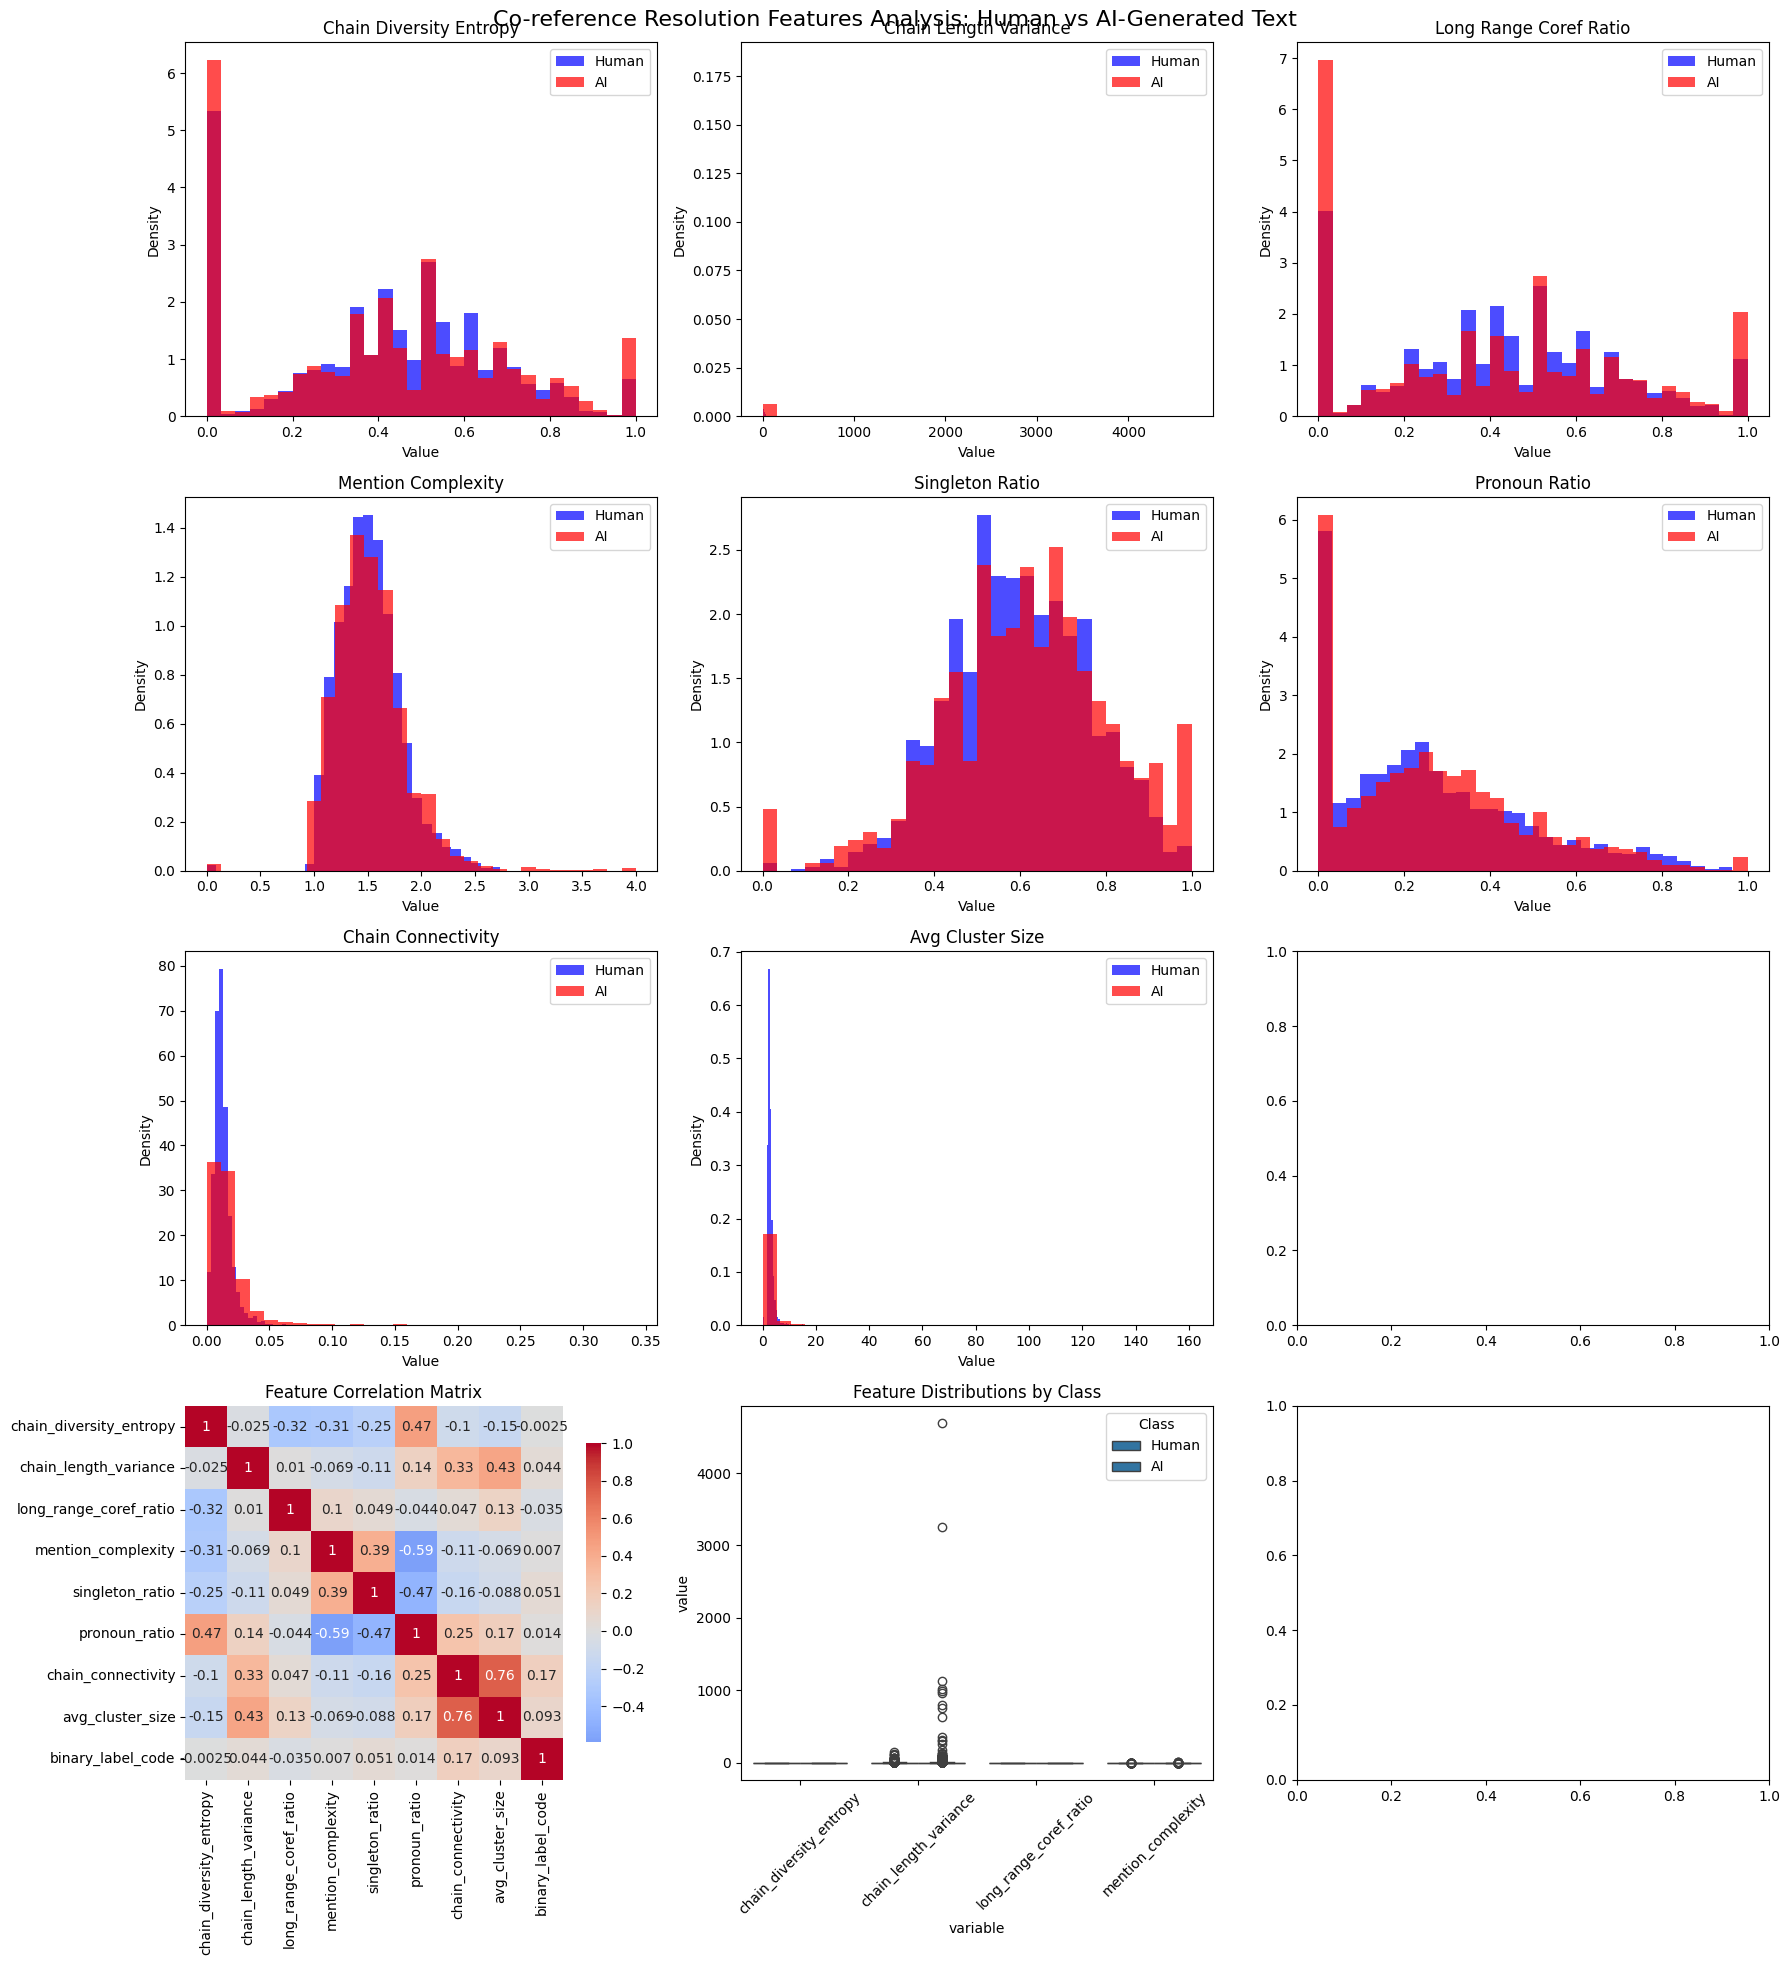


Step 2: Statistical validation...
=== STATISTICAL VALIDATION RESULTS ===

1. T-TEST RESULTS (Human vs AI):
------------------------------------------------------------
Feature                   t-stat   p-value    Effect Size  Significant
------------------------------------------------------------
chain_diversity_entropy     0.160    0.8725       0.005            
chain_length_variance      -2.801    0.0051      -0.089          **
long_range_coref_ratio      2.210    0.0271       0.070           *
mention_complexity         -0.441    0.6595      -0.014            
singleton_ratio            -3.236    0.0012      -0.102          **
pronoun_ratio              -0.907    0.3643      -0.029            
chain_connectivity        -10.613    0.0000      -0.336         ***
avg_cluster_size           -5.875    0.0000      -0.186         ***

2. MUTUAL INFORMATION SCORES:
----------------------------------------
chain_connectivity       : 0.0529
avg_cluster_size         : 0.0446
chain_length_va

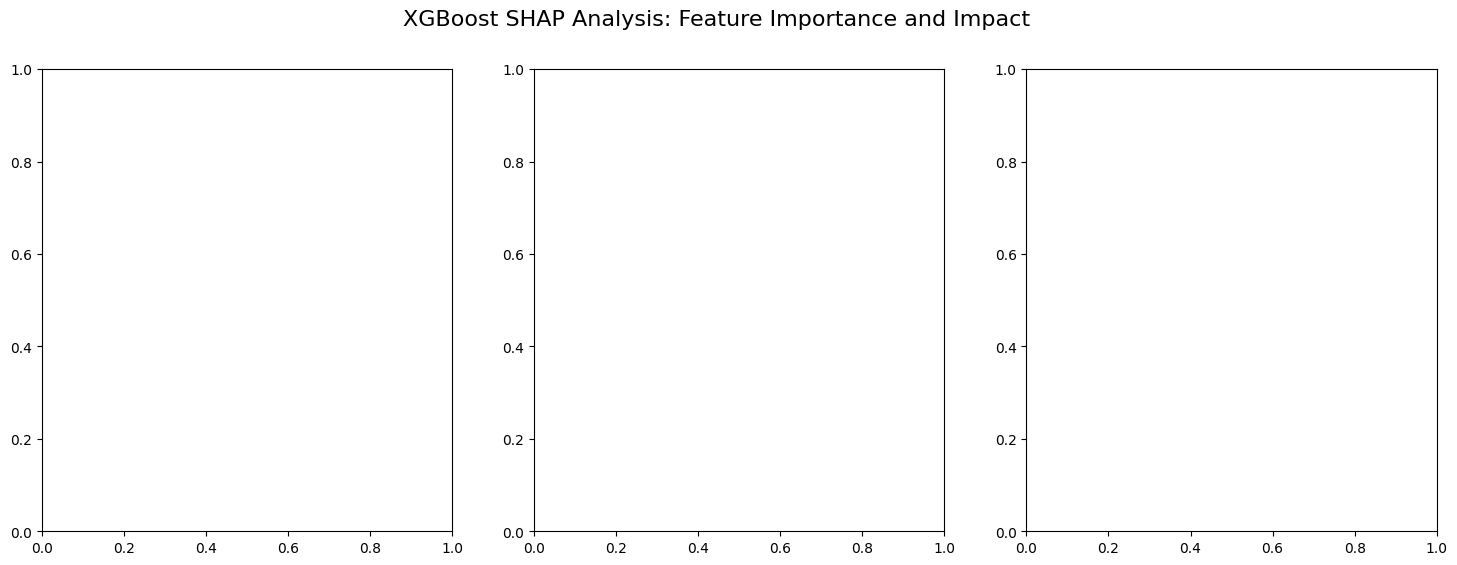

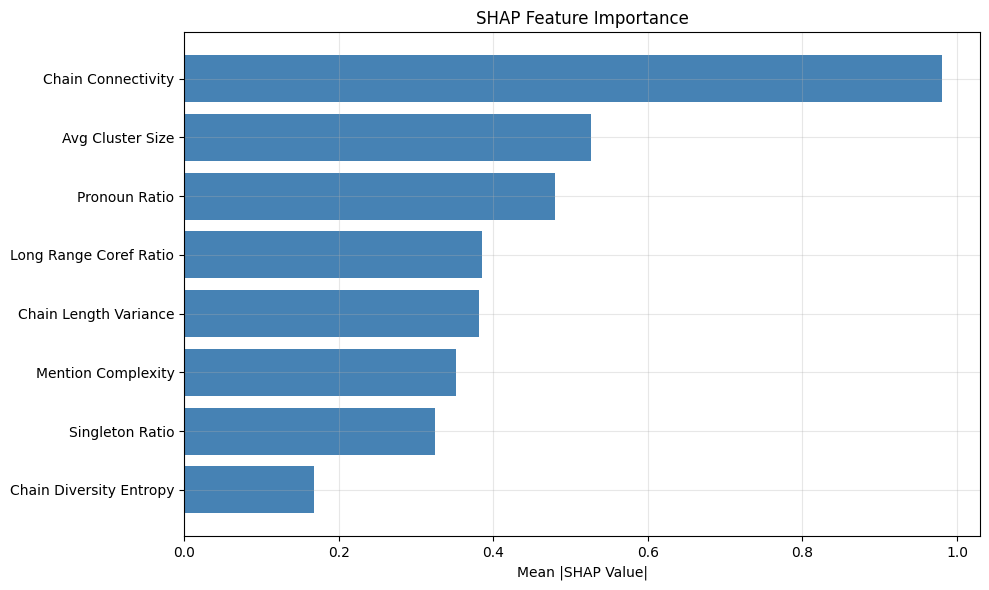


Step 5: Feature worthiness evaluation...
=== FEATURE WORTHINESS EVALUATION ===

FEATURE WORTHINESS SCORES:
--------------------------------------------------------------------------------
Feature                   Score  Recommendation  Key Criteria
--------------------------------------------------------------------------------
chain_connectivity        8      MUST INCLUDE    Statistically Significant, Small Effect Size
avg_cluster_size          5      INCLUDE         Statistically Significant, High Mutual Information
chain_length_variance     3      CONSIDER        Statistically Significant, Moderate Mutual Information
singleton_ratio           3      CONSIDER        Statistically Significant, Moderate Mutual Information
long_range_coref_ratio    2      EXCLUDE         Statistically Significant
pronoun_ratio             1      EXCLUDE         Moderate SHAP Importance
chain_diversity_entropy   0      EXCLUDE         
mention_complexity        0      EXCLUDE         

=== SUMMARY ===


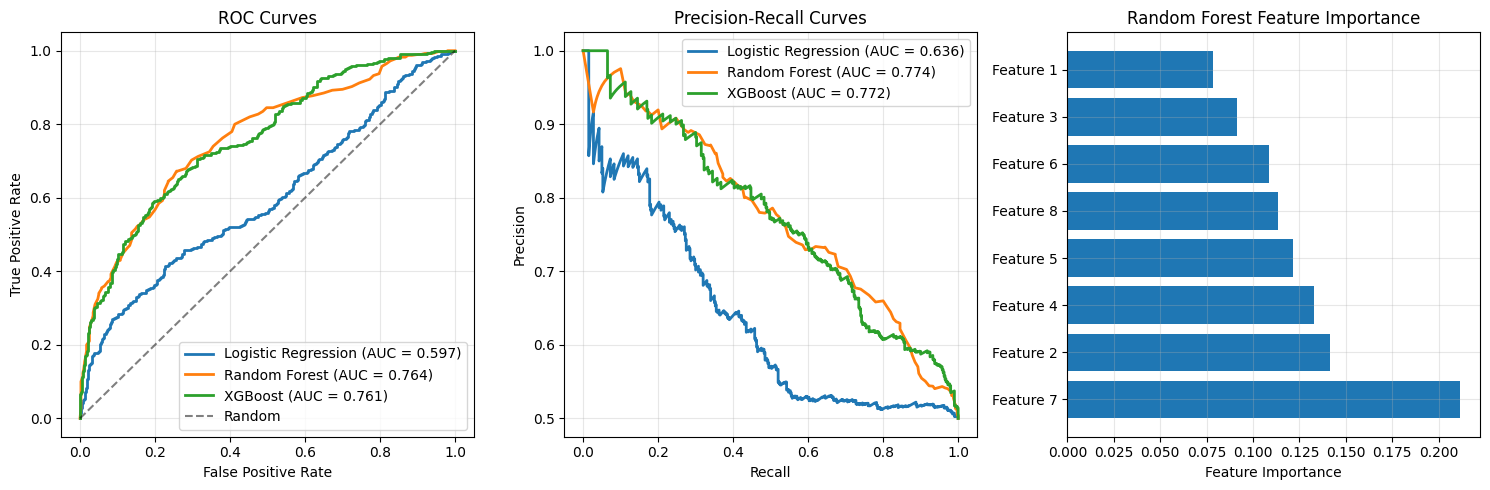


Step 7: Comparison with existing features...
=== FEATURE COMPARISON ANALYSIS ===

LOGISTIC REGRESSION COMPARISON:
--------------------------------------------------
ROC-AUC new features only: 0.597
ROC-AUC existing features only: 0.742
ROC-AUC combined features: 0.750
Improvement: +0.008

XGBOOST + SHAP ANALYSIS:
--------------------------------------------------
XGBoost AUC: 0.935


 98%|===================| 784/800 [00:12<00:00]       


Top 10 Features:
🔵 gpt2_perplexity                | 2.7020
🔵 type_token_ratio               | 2.1369
🔵 flesch_reading_ease            | 0.9452
🔵 pos_transition_entropy         | 0.8569
🔵 unique_3grams                  | 0.7345
🔵 repeated_3gram_ratio           | 0.7167
🔵 unique_2grams                  | 0.6515
🔵 sentence_length_std            | 0.5438
🔵 sentence_length_entropy        | 0.5227
🔴 mention_complexity             | 0.5221

New Features Performance:
  chain_diversity_entropy   | Rank # 1 | SHAP: 0.2452
  chain_length_variance     | Rank # 2 | SHAP: 0.3413
  long_range_coref_ratio    | Rank # 3 | SHAP: 0.2269
  mention_complexity        | Rank # 4 | SHAP: 0.5221
  singleton_ratio           | Rank # 5 | SHAP: 0.4020
  pronoun_ratio             | Rank # 6 | SHAP: 0.5091
  chain_connectivity        | Rank # 7 | SHAP: 0.3644
  avg_cluster_size          | Rank # 8 | SHAP: 0.2431

Summary:
New features in top 10: 1/8
New features mean importance: 0.3568
Existing features mean impor

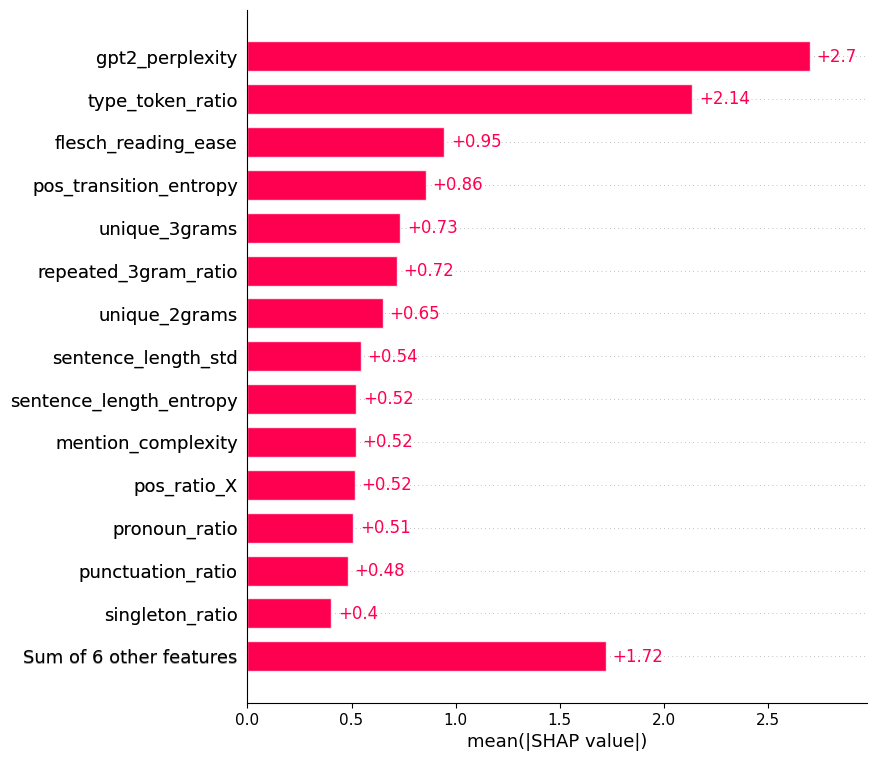


💡 Recommendation: 🟠 WEAK: Limited benefit from new features

Co-reference Resolution Features analysis complete!

DETAILED CO-REFERENCE FEATURE BREAKDOWN

🎯 CHAIN DIVERSITY ENTROPY
--------------------------------------------------
Basic Stats    : Mean=0.4096, Std=0.2714
Data Quality   : Non-zero=3229/4000 (80.7%)
Class Diff     : Human=0.4103, AI=0.4089, Diff=0.0014
Significance   : p=0.8725 , Effect=0.0051, Corr=-0.0025
SHAP Impact    : 0.1676
Overall Rank   : #1

🎯 CHAIN LENGTH VARIANCE
--------------------------------------------------
Basic Stats    : Mean=7.4667, Std=98.7894
Data Quality   : Non-zero=3899/4000 (97.5%)
Class Diff     : Human=3.0949, AI=11.8385, Diff=-8.7436
Significance   : p=0.0051 **, Effect=-0.0886, Corr=0.0443
SHAP Impact    : 0.3813
Overall Rank   : #2

🎯 LONG RANGE COREF RATIO
--------------------------------------------------
Basic Stats    : Mean=0.4128, Std=0.2866
Data Quality   : Non-zero=3269/4000 (81.7%)
Class Diff     : Human=0.4229, AI=0.4028, Diff

In [ ]:
# Complete Co-reference Resolution Feature Analysis - Exact Format
from Analyse_feature import FeatureAnalyzer
from scipy import stats
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("🧬 CO-REFERENCE RESOLUTION FEATURE ANALYSIS")
print("=" * 80)

# Load dataset
print("📊 Loading dataset...")
df = df_subset.copy()
print(f"✅ Dataset loaded: {df.shape}")

print("\n🔍 Extracting co-reference features...")
# Extract co-reference features using your working extractor
df_with_coref = extractor.extract_coref_features(df, text_column='generation')

# Setup analysis
analyzer = FeatureAnalyzer()

# Your working coreference features
coref_features = [
    'chain_diversity_entropy',
    'chain_length_variance',
    'long_range_coref_ratio',
    'mention_complexity',
    'singleton_ratio',
    'pronoun_ratio',
    'chain_connectivity',
    'avg_cluster_size'
]

# Filter to only features that exist and have data
existing_coref_features = []
for feature in coref_features:
    if feature in df_with_coref.columns:
        non_zero_count = (df_with_coref[feature] > 0).sum()
        if non_zero_count > 0:  # Only include features with some non-zero values
            existing_coref_features.append(feature)

print(f"📊 Available coreference features: {len(existing_coref_features)}")
print(f"🎯 Features: {existing_coref_features}")

# Get existing features for comparison
exclude_cols = set(existing_coref_features + ['binary_label_code', 'binary_label', 'generation', 'text', 'id', 'source_id', 'adv_source_id'])
existing_features = [col for col in df_with_coref.columns
                    if col not in exclude_cols and pd.api.types.is_numeric_dtype(df_with_coref[col])]

print(f"\n🎯 Analysis setup:")
print(f"Co-reference features: {existing_coref_features}")
print(f"Existing features for comparison: {len(existing_features)}")

# Run comprehensive analysis
print(f"\n📈 Running comprehensive analysis...")
results = analyzer.analyze_features(
    df=df_with_coref,
    feature_names=existing_coref_features,
    target_col='binary_label_code',
    feature_type_name="Co-reference Resolution Features",
    existing_features=existing_features if existing_features else None
)

# Extract results for detailed breakdown
stats_results = results['stats_results']
model_results = results['model_results']
shap_results = results['shap_results']
comparison_results = results['comparison_results']

# Feature-by-feature detailed breakdown
print(f"\n" + "="*80)
print("DETAILED CO-REFERENCE FEATURE BREAKDOWN")
print("="*80)

feature_analysis = {}
for feature in existing_coref_features:
    print(f"\n🎯 {feature.upper().replace('_', ' ')}")
    print("-" * 50)

    # Basic statistics
    feature_data = df_with_coref[feature]
    mean_val = feature_data.mean()
    std_val = feature_data.std()
    non_zero_count = (feature_data > 0).sum()
    zero_ratio = (feature_data == 0).sum() / len(feature_data)

    # Class comparison
    human_data = df_with_coref[df_with_coref['binary_label_code'] == 0][feature]
    ai_data = df_with_coref[df_with_coref['binary_label_code'] == 1][feature]
    human_mean = human_data.mean()
    ai_mean = ai_data.mean()
    difference = human_mean - ai_mean

    # Statistical tests
    t_stat, p_value = stats.ttest_ind(human_data, ai_data, equal_var=False)
    if (human_data.var() + ai_data.var()) > 0:
        effect_size = difference / np.sqrt((human_data.var() + ai_data.var()) / 2)
    else:
        effect_size = 0.0
    correlation = feature_data.corr(df_with_coref['binary_label_code'])

    # SHAP importance
    shap_importance = 0
    comparison_rank = "N/A"
    if shap_results and 'feature_importance' in shap_results:
        shap_importance = shap_results['feature_importance'].get(feature, 0)
    if comparison_results and 'importance_df' in comparison_results:
        importance_df = comparison_results['importance_df']
        if feature in importance_df['feature'].values:
            comparison_rank = importance_df[importance_df['feature'] == feature].index[0] + 1

    print(f"Basic Stats    : Mean={mean_val:.4f}, Std={std_val:.4f}")
    print(f"Data Quality   : Non-zero={non_zero_count}/{len(df_with_coref)} ({100*(1-zero_ratio):.1f}%)")
    print(f"Class Diff     : Human={human_mean:.4f}, AI={ai_mean:.4f}, Diff={difference:.4f}")
    print(f"Significance   : p={p_value:.4f} {'***' if p_value<0.001 else '**' if p_value<0.01 else '*' if p_value<0.05 else ''}, Effect={effect_size:.4f}, Corr={correlation:.4f}")
    print(f"SHAP Impact    : {shap_importance:.4f}")
    print(f"Overall Rank   : #{comparison_rank}")

    feature_analysis[feature] = {
        'p_value': p_value, 'effect_size': abs(effect_size), 'correlation': abs(correlation),
        'shap_importance': shap_importance, 'comparison_rank': comparison_rank if comparison_rank != "N/A" else 999,
        'mean_value': mean_val, 'class_difference': abs(difference), 'zero_ratio': zero_ratio,
        'data_quality': 1 - zero_ratio, 't_stat': t_stat,
        'human_mean': human_mean, 'ai_mean': ai_mean
    }

# Feature scoring and selection
print(f"\n" + "="*80)
print("CO-REFERENCE FEATURE INCLUSION DECISION")
print("="*80)

feature_scores = {}
for feature, data in feature_analysis.items():
    score = 0
    reasons = []

    # Statistical significance (higher weight)
    if data['p_value'] < 0.001:
        score += 5
        reasons.append("Highly significant (p<0.001)")
    elif data['p_value'] < 0.01:
        score += 4
        reasons.append("Very significant (p<0.01)")
    elif data['p_value'] < 0.05:
        score += 3
        reasons.append("Significant (p<0.05)")
    elif data['p_value'] < 0.1:
        score += 2
        reasons.append("Marginally significant (p<0.1)")

    # Effect size
    if data['effect_size'] > 0.8:
        score += 4
        reasons.append("Large effect")
    elif data['effect_size'] > 0.5:
        score += 3
        reasons.append("Medium effect")
    elif data['effect_size'] > 0.2:
        score += 2
        reasons.append("Small effect")
    elif data['effect_size'] > 0.1:
        score += 1
        reasons.append("Minimal effect")

    # Correlation strength
    if data['correlation'] > 0.3:
        score += 4
        reasons.append("Strong correlation")
    elif data['correlation'] > 0.2:
        score += 3
        reasons.append("Moderate correlation")
    elif data['correlation'] > 0.1:
        score += 2
        reasons.append("Weak correlation")
    elif data['correlation'] > 0.05:
        score += 1
        reasons.append("Very weak correlation")

    # SHAP importance
    if data['shap_importance'] > 0.5:
        score += 6
        reasons.append("Very high SHAP importance")
    elif data['shap_importance'] > 0.3:
        score += 4
        reasons.append("High SHAP importance")
    elif data['shap_importance'] > 0.2:
        score += 3
        reasons.append("Moderate SHAP importance")
    elif data['shap_importance'] > 0.1:
        score += 2
        reasons.append("Low SHAP importance")
    elif data['shap_importance'] > 0.05:
        score += 1
        reasons.append("Minimal SHAP importance")

    # Ranking bonus
    if data['comparison_rank'] <= 5:
        score += 4
        reasons.append(f"Top 5 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 10:
        score += 3
        reasons.append(f"Top 10 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 15:
        score += 2
        reasons.append(f"Top 15 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 20:
        score += 1
        reasons.append(f"Top 20 rank (#{data['comparison_rank']})")

    # Data quality bonus
    if data['data_quality'] > 0.9:
        score += 3
        reasons.append("Excellent data quality")
    elif data['data_quality'] > 0.8:
        score += 2
        reasons.append("High data quality")
    elif data['data_quality'] > 0.6:
        score += 1
        reasons.append("Good data quality")
    elif data['data_quality'] < 0.3:
        score -= 2
        reasons.append("Poor data quality")

    # Practical significance
    if data['class_difference'] > 0.1:
        score += 2
        reasons.append("Large practical difference")
    elif data['class_difference'] > 0.05:
        score += 1
        reasons.append("Moderate practical difference")

    feature_scores[feature] = {'score': score, 'reasons': reasons}

# Display results
print(f"\n🏆 CO-REFERENCE FEATURE SCORING RESULTS:")
print(f"{'Feature':<25} {'Score':<6} {'Decision':<12} {'SHAP':<8} {'Rank':<6} {'Reasons'}")
print("-" * 100)

# Sort by SHAP importance first, then by score
shap_sorted_features = sorted(existing_coref_features,
                             key=lambda x: (feature_analysis[x]['shap_importance'],
                                          feature_scores[x]['score']), reverse=True)

recommended_features = []
for feature in shap_sorted_features:
    score = feature_scores[feature]['score']
    reasons = feature_scores[feature]['reasons']
    shap_val = feature_analysis[feature]['shap_importance']
    rank_val = feature_analysis[feature]['comparison_rank']

    # Decision logic
    if score >= 15:
        decision = "🟢 MUST INCLUDE"
        recommended_features.append(feature)
    elif score >= 10:
        decision = "✅ INCLUDE"
        recommended_features.append(feature)
    elif score >= 6:
        decision = "🟡 CONSIDER"
        if shap_val > 0.1 or feature_analysis[feature]['p_value'] < 0.05:
            recommended_features.append(feature)
    elif score >= 3:
        decision = "🟠 MAYBE"
        if shap_val > 0.2:
            recommended_features.append(feature)
    else:
        decision = "❌ EXCLUDE"

    reasons_str = ", ".join(reasons[:2]) + ("..." if len(reasons) > 2 else "")
    print(f"{feature:<25} {score:<6} {decision:<12} {shap_val:<8.3f} #{rank_val:<5} {reasons_str}")

# Final recommendation section
print(f"\n" + "="*80)
print("FINAL CO-REFERENCE FEATURE RECOMMENDATION")
print("="*80)

if comparison_results:
    improvement = comparison_results['improvement']
    print(f"📊 Overall Performance Impact: +{improvement:.4f} AUC improvement")

print(f"\n💡 RECOMMENDED CO-REFERENCE FEATURES TO INCLUDE:")

if recommended_features:
    for feature in recommended_features:
        score = feature_scores[feature]['score']
        rank = feature_analysis[feature]['comparison_rank']
        shap = feature_analysis[feature]['shap_importance']
        p_val = feature_analysis[feature]['p_value']
        quality = feature_analysis[feature]['data_quality']
        print(f"   ✅ {feature:<25} (Score: {score}/23, Rank: #{rank}, SHAP: {shap:.3f}, p: {p_val:.3f}, Quality: {quality:.3f})")

    print(f"\n📁 READY FOR INCLUSION:")
    print(f"   Co-reference features to add: {recommended_features}")

    print(f"\n📈 FEATURE PERFORMANCE:")
    for feature in recommended_features:
        human_vals = df_with_coref[df_with_coref['binary_label_code'] == 0][feature]
        ai_vals = df_with_coref[df_with_coref['binary_label_code'] == 1][feature]
        print(f"   • {feature}: Human μ={human_vals.mean():.4f}, AI μ={ai_vals.mean():.4f}")

    # Store results globally
    globals()['df_with_coref'] = df_with_coref
    globals()['coref_features_to_merge'] = recommended_features
    globals()['coref_analysis_results'] = results

    print(f"\n✅ SUCCESS: Co-reference features ready for integration!")
    print(f"📊 Enhanced DataFrame: 'df_with_coref' ({df_with_coref.shape})")
    print(f"🎯 Recommended features: 'coref_features_to_merge' ({len(recommended_features)} features)")

else:
    print(f"   ❌ NO CO-REFERENCE FEATURES MEET INCLUSION CRITERIA")
    print(f"📊 However, 'df_with_coref' contains all extracted features for manual review")

print(f"\n🏁 Co-reference analysis complete!")

# Optional: Save analysis summary
if len(existing_coref_features) > 0:
    analysis_summary = pd.DataFrame({
        'feature': list(feature_analysis.keys()),
        'score': [feature_scores[f]['score'] for f in feature_analysis.keys()],
        'p_value': [feature_analysis[f]['p_value'] for f in feature_analysis.keys()],
        'effect_size': [feature_analysis[f]['effect_size'] for f in feature_analysis.keys()],
        'shap_importance': [feature_analysis[f]['shap_importance'] for f in feature_analysis.keys()],
        'correlation': [feature_analysis[f]['correlation'] for f in feature_analysis.keys()],
        'data_quality': [feature_analysis[f]['data_quality'] for f in feature_analysis.keys()],
        'rank': [feature_analysis[f]['comparison_rank'] for f in feature_analysis.keys()],
        'recommended': [f in recommended_features for f in feature_analysis.keys()],
        'human_mean': [feature_analysis[f]['human_mean'] for f in feature_analysis.keys()],
        'ai_mean': [feature_analysis[f]['ai_mean'] for f in feature_analysis.keys()]
    })

    analysis_summary.to_csv('coreference_analysis_summary.csv', index=False)
    print(f"\n📁 Analysis summary saved to: coreference_analysis_summary.csv")

🧬 CO-REFERENCE RESOLUTION FEATURE ANALYSIS
📊 Loading dataset...
✅ Dataset loaded: (16000, 18)

🔍 Extracting co-reference features...
🔍 Advanced Heuristic extracting co-reference features from 16000 texts...
Method: Multi-Strategy Advanced Heuristic Coreference Resolution


Advanced Processing:   5%|▌         | 837/16000 [00:48<14:34, 17.34it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  10%|▉         | 1535/16000 [01:29<19:25, 12.41it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  10%|▉         | 1584/16000 [01:32<13:05, 18.36it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  14%|█▎        | 2168/16000 [02:05<14:23, 16.03it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  14%|█▍        | 2291/16000 [02:13<11:05, 20.59it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  19%|█▉        | 3069/16000 [02:57<17:29, 12.32it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  22%|██▏       | 3534/16000 [03:23<15:19, 13.56it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  22%|██▏       | 3544/16000 [03:24<18:11, 11.41it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  24%|██▍       | 3899/16000 [03:43<09:19, 21.61it/s]

⚠️ Error in feature extraction: division by zero
⚠️ Error in feature extraction: division by zero


Advanced Processing:  26%|██▌       | 4080/16000 [03:54<09:33, 20.78it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  28%|██▊       | 4467/16000 [04:16<10:59, 17.48it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  33%|███▎      | 5261/16000 [05:01<09:12, 19.45it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  33%|███▎      | 5304/16000 [05:03<08:09, 21.87it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  35%|███▍      | 5580/16000 [05:19<10:05, 17.22it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  39%|███▉      | 6213/16000 [05:55<11:39, 14.00it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  40%|████      | 6401/16000 [06:06<07:33, 21.16it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  44%|████▍     | 7000/16000 [06:40<07:11, 20.84it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  46%|████▌     | 7312/16000 [06:57<06:46, 21.38it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  51%|█████▏    | 8225/16000 [07:47<06:24, 20.21it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  57%|█████▋    | 9139/16000 [08:38<04:58, 22.95it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  58%|█████▊    | 9315/16000 [08:48<05:11, 21.47it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  63%|██████▎   | 10128/16000 [09:33<04:32, 21.57it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  69%|██████▉   | 11025/16000 [10:24<05:09, 16.05it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  72%|███████▏  | 11480/16000 [10:49<07:16, 10.35it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  75%|███████▌  | 12048/16000 [11:20<03:00, 21.93it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  76%|███████▋  | 12219/16000 [11:30<03:38, 17.30it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  79%|███████▊  | 12574/16000 [11:49<03:19, 17.16it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  79%|███████▊  | 12578/16000 [11:49<03:13, 17.67it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  79%|███████▉  | 12637/16000 [11:54<03:18, 16.96it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  80%|███████▉  | 12735/16000 [11:58<02:42, 20.06it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  82%|████████▏ | 13060/16000 [12:17<04:02, 12.15it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing:  89%|████████▉ | 14208/16000 [13:21<02:51, 10.44it/s]

⚠️ Error in feature extraction: division by zero


Advanced Processing: 100%|██████████| 16000/16000 [15:04<00:00, 17.69it/s]


✅ Advanced extraction complete: 15952/16000 successful
⚠️  Failed extractions: 48

📊 Advanced Feature Statistics:
chain_diversity_entropy: μ=0.4002, σ=0.2684, non-zero=12777/16000 (79.9%)
chain_length_variance: μ=6.9030, σ=79.5852, non-zero=15606/16000 (97.5%)
long_range_coref_ratio: μ=0.4233, σ=0.2875, non-zero=13232/16000 (82.7%)
mention_complexity: μ=1.5323, σ=0.3240, non-zero=15952/16000 (99.7%)
singleton_ratio: μ=0.6044, σ=0.1793, non-zero=15862/16000 (99.1%)
pronoun_ratio: μ=0.2571, σ=0.2153, non-zero=12965/16000 (81.0%)
chain_connectivity: μ=0.0143, σ=0.0163, non-zero=15630/16000 (97.7%)
avg_cluster_size: μ=3.3939, σ=4.8091, non-zero=15640/16000 (97.8%)
📊 Available coreference features: 8
🎯 Features: ['chain_diversity_entropy', 'chain_length_variance', 'long_range_coref_ratio', 'mention_complexity', 'singleton_ratio', 'pronoun_ratio', 'chain_connectivity', 'avg_cluster_size']

🎯 Analysis setup:
Co-reference features: ['chain_diversity_entropy', 'chain_length_variance', 'long_ran

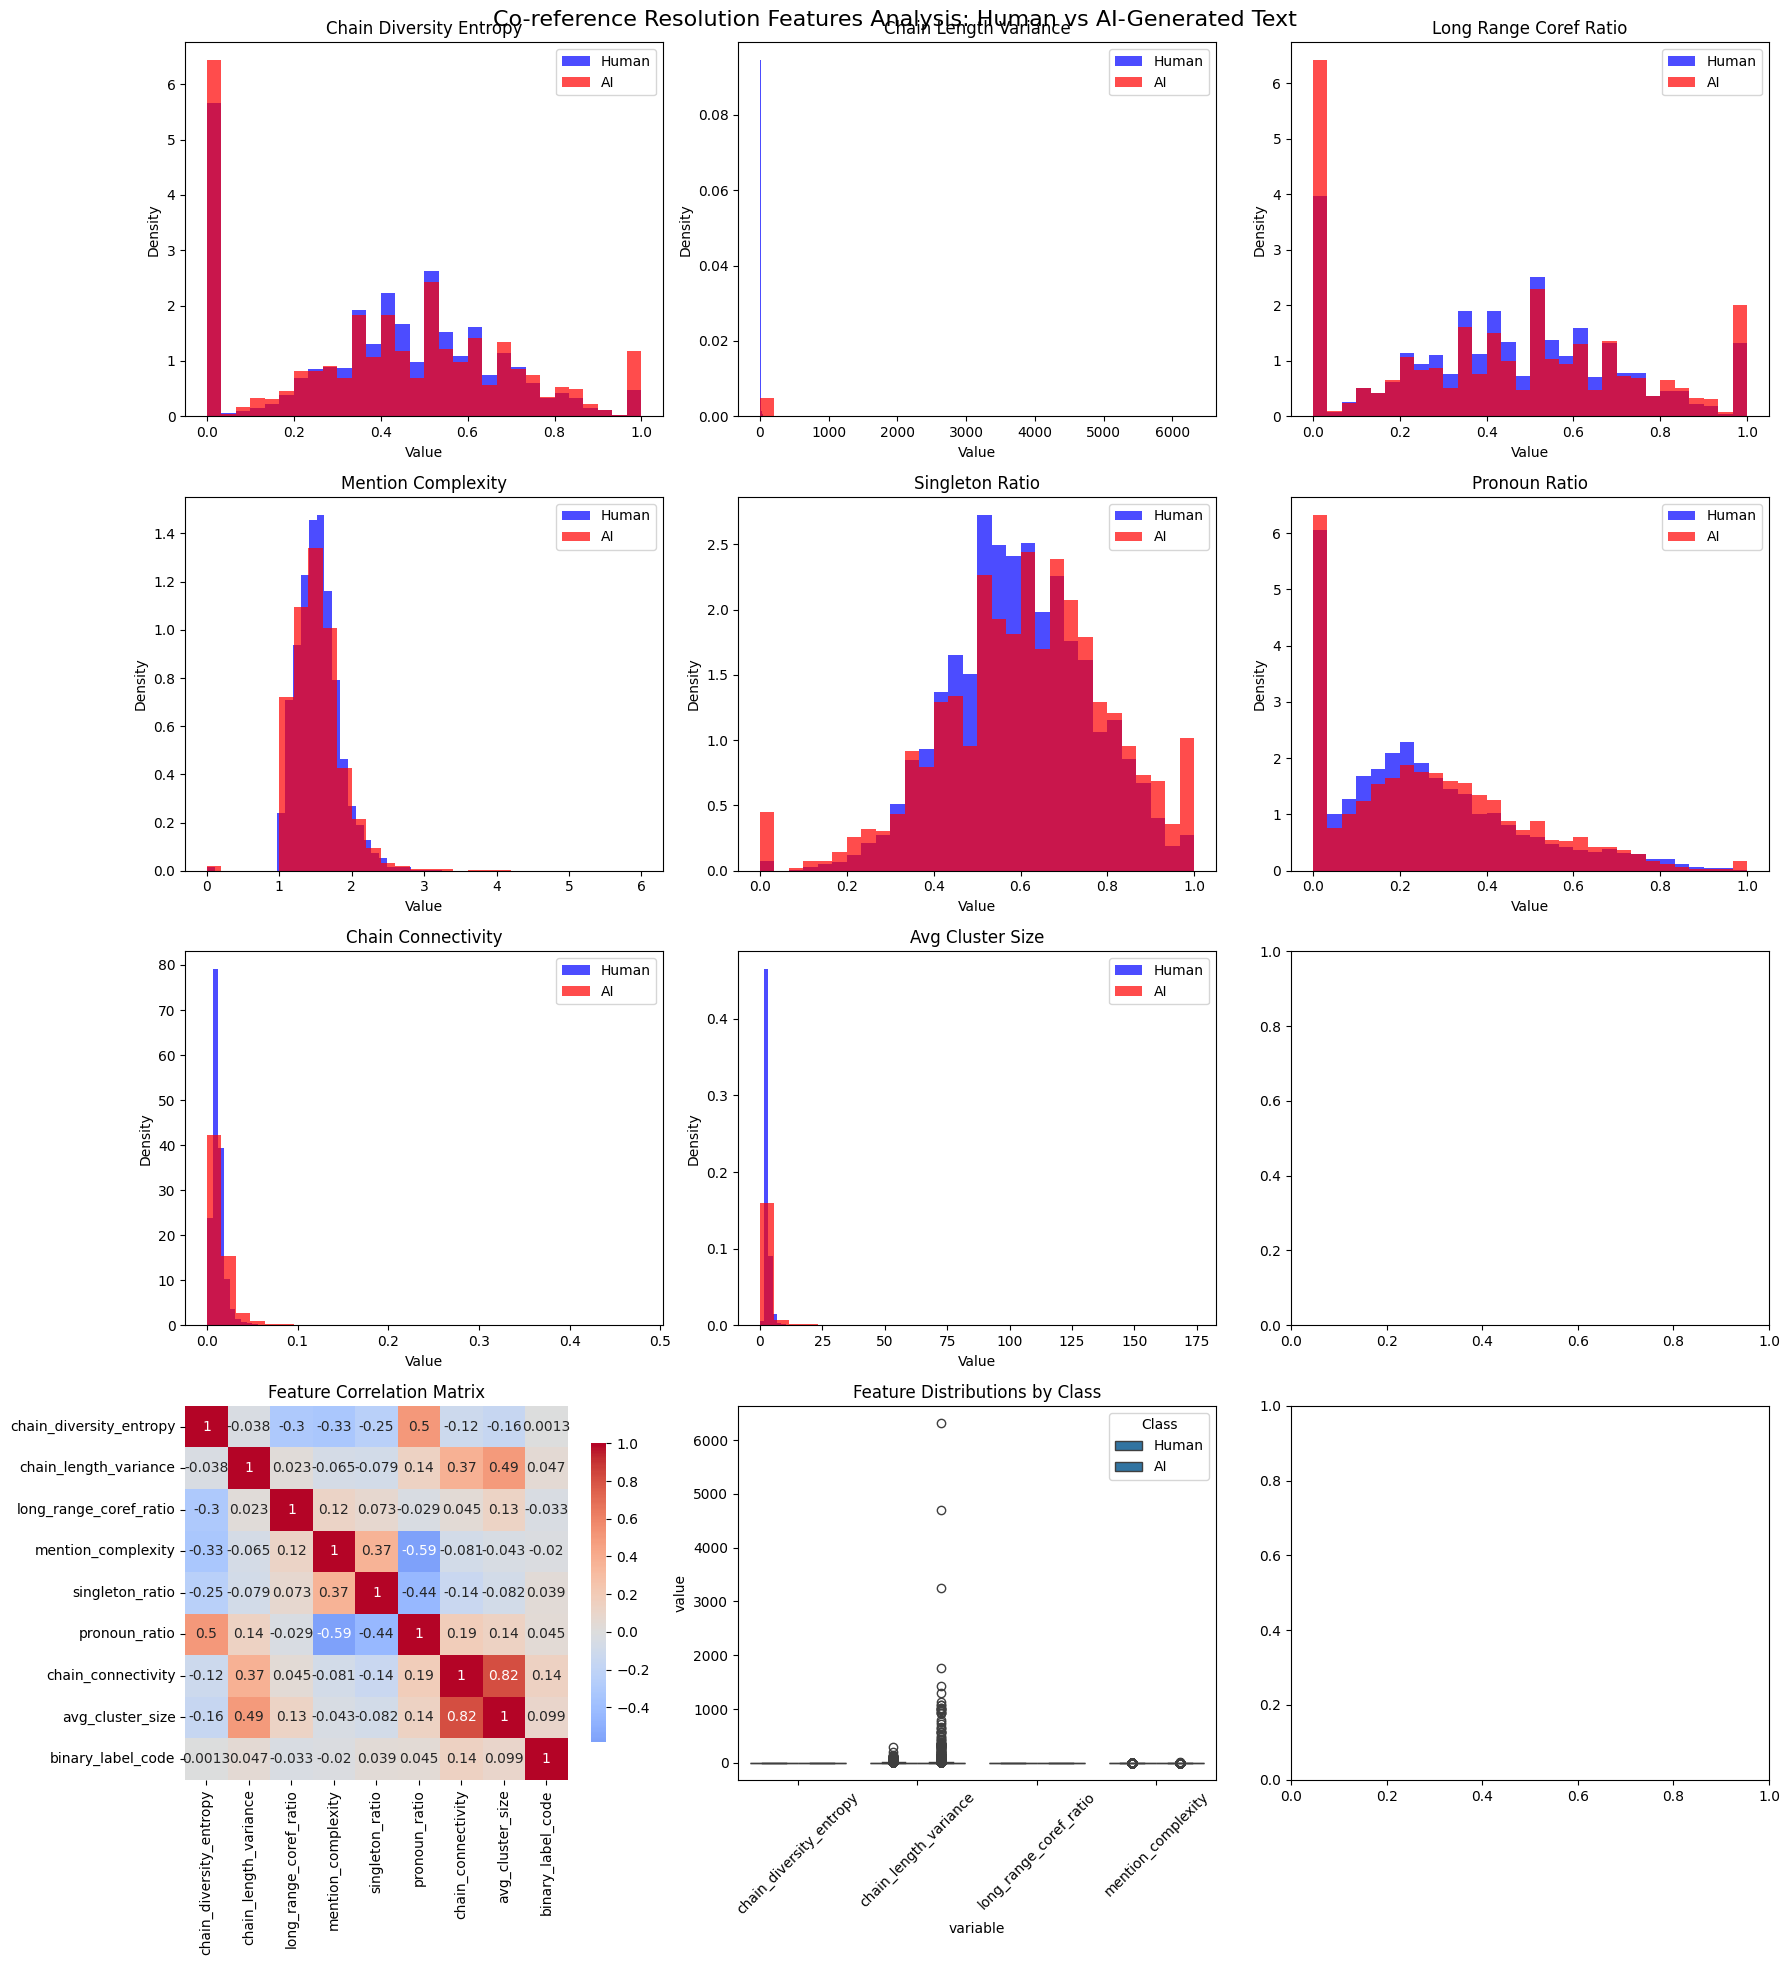


Step 2: Statistical validation...
=== STATISTICAL VALIDATION RESULTS ===

1. T-TEST RESULTS (Human vs AI):
------------------------------------------------------------
Feature                   t-stat   p-value    Effect Size  Significant
------------------------------------------------------------
chain_diversity_entropy    -0.159    0.8736      -0.003            
chain_length_variance      -5.911    0.0000      -0.093         ***
long_range_coref_ratio      4.154    0.0000       0.066         ***
mention_complexity          2.489    0.0128       0.039           *
singleton_ratio            -4.982    0.0000      -0.079         ***
pronoun_ratio              -5.701    0.0000      -0.090         ***
chain_connectivity        -18.376    0.0000      -0.291         ***
avg_cluster_size          -12.583    0.0000      -0.199         ***

2. MUTUAL INFORMATION SCORES:
----------------------------------------
chain_connectivity       : 0.0487
avg_cluster_size         : 0.0294
chain_length_va

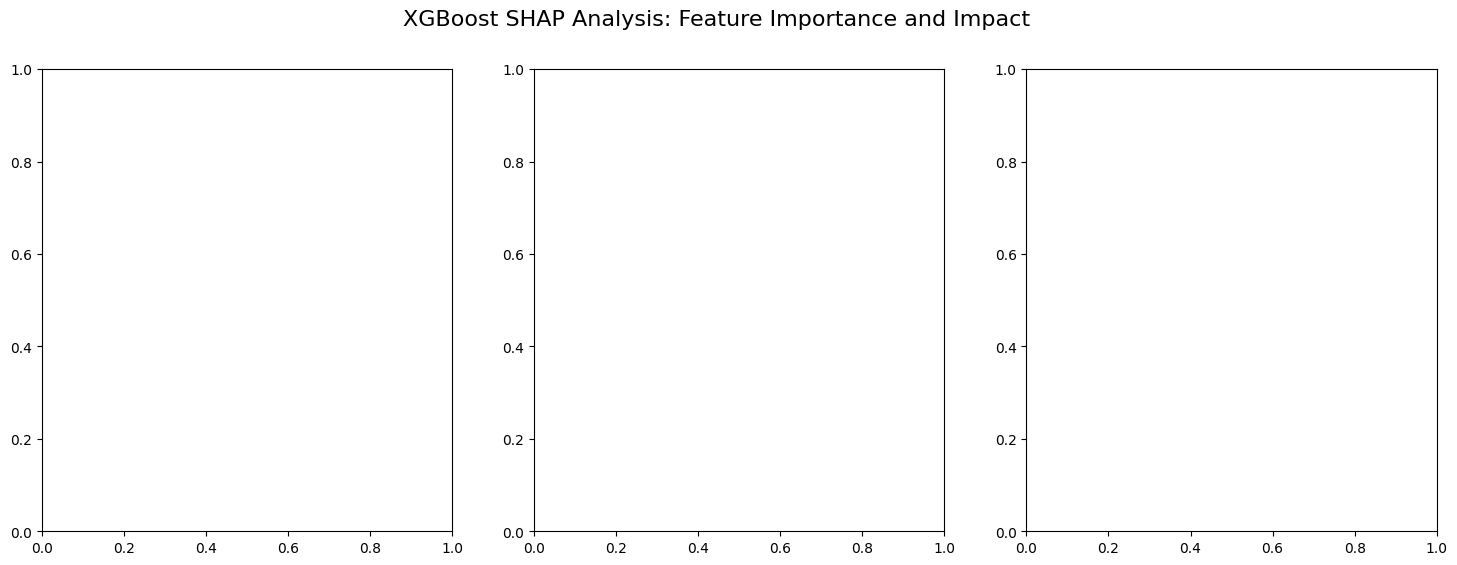

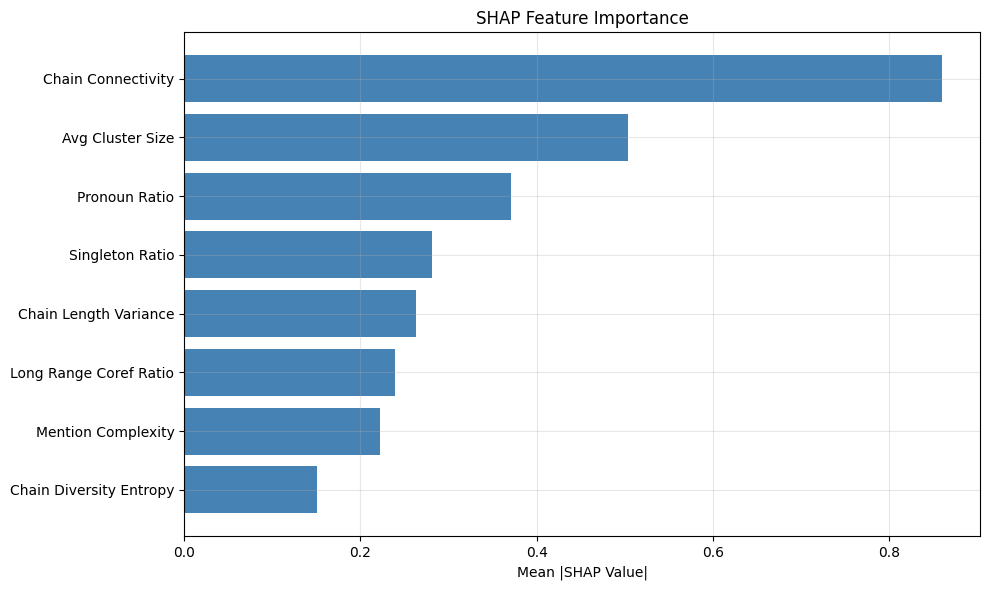


Step 5: Feature worthiness evaluation...
=== FEATURE WORTHINESS EVALUATION ===

FEATURE WORTHINESS SCORES:
--------------------------------------------------------------------------------
Feature                   Score  Recommendation  Key Criteria
--------------------------------------------------------------------------------
chain_connectivity        8      MUST INCLUDE    Statistically Significant, Small Effect Size
avg_cluster_size          4      CONSIDER        Statistically Significant, Moderate Mutual Information
chain_length_variance     3      CONSIDER        Statistically Significant, Moderate Mutual Information
singleton_ratio           3      CONSIDER        Statistically Significant, Moderate Mutual Information
pronoun_ratio             3      CONSIDER        Statistically Significant, Moderate SHAP Importance
long_range_coref_ratio    2      EXCLUDE         Statistically Significant
mention_complexity        2      EXCLUDE         Statistically Significant
chain_diver

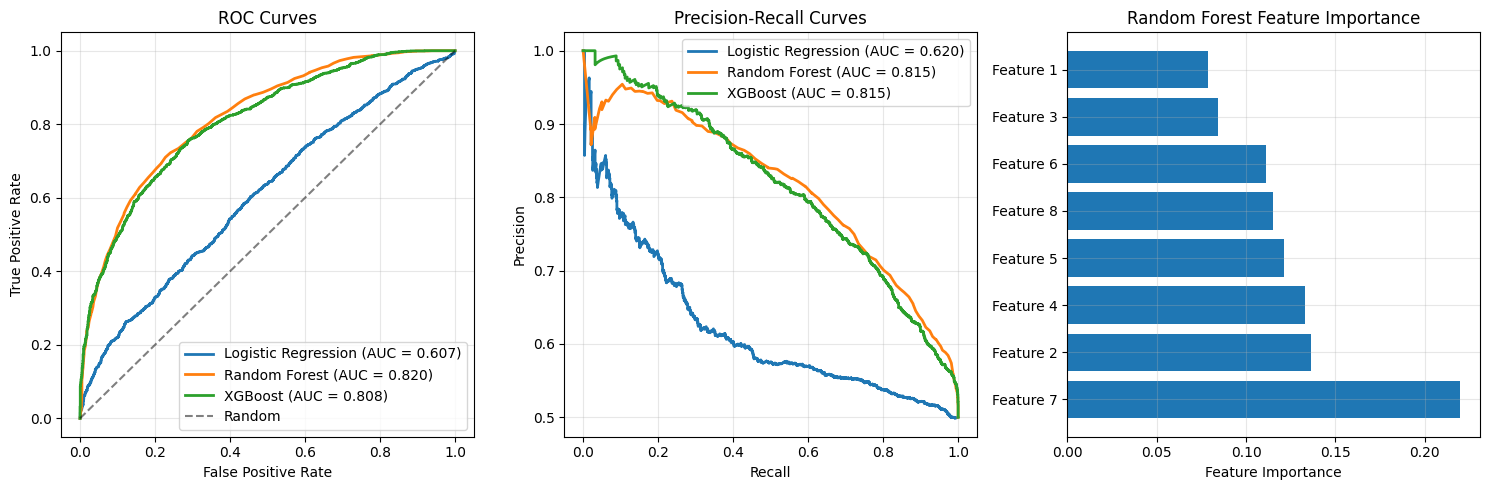


Step 7: Comparison with existing features...
=== FEATURE COMPARISON ANALYSIS ===

LOGISTIC REGRESSION COMPARISON:
--------------------------------------------------
ROC-AUC new features only: 0.607
ROC-AUC existing features only: 0.704
ROC-AUC combined features: 0.736
Improvement: +0.031

XGBOOST + SHAP ANALYSIS:
--------------------------------------------------
XGBoost AUC: 0.949


 99%|===================| 3168/3200 [00:56<00:00]       


Top 10 Features:
🔵 gpt2_perplexity                | 2.4221
🔵 type_token_ratio               | 2.0230
🔵 unique_3grams                  | 0.9751
🔵 pos_transition_entropy         | 0.6892
🔴 pronoun_ratio                  | 0.6772
🔵 sentence_length_std            | 0.6074
🔵 punctuation_ratio              | 0.5832
🔵 flesch_reading_ease            | 0.5395
🔵 sentence_length_entropy        | 0.5211
🔵 pos_ratio_X                    | 0.4844

New Features Performance:
  chain_diversity_entropy   | Rank # 1 | SHAP: 0.1319
  chain_length_variance     | Rank # 2 | SHAP: 0.3793
  long_range_coref_ratio    | Rank # 3 | SHAP: 0.1476
  mention_complexity        | Rank # 4 | SHAP: 0.3583
  singleton_ratio           | Rank # 5 | SHAP: 0.3044
  pronoun_ratio             | Rank # 6 | SHAP: 0.6772
  chain_connectivity        | Rank # 7 | SHAP: 0.4566
  avg_cluster_size          | Rank # 8 | SHAP: 0.2812

Summary:
New features in top 10: 1/8
New features mean importance: 0.3421
Existing features mean impor

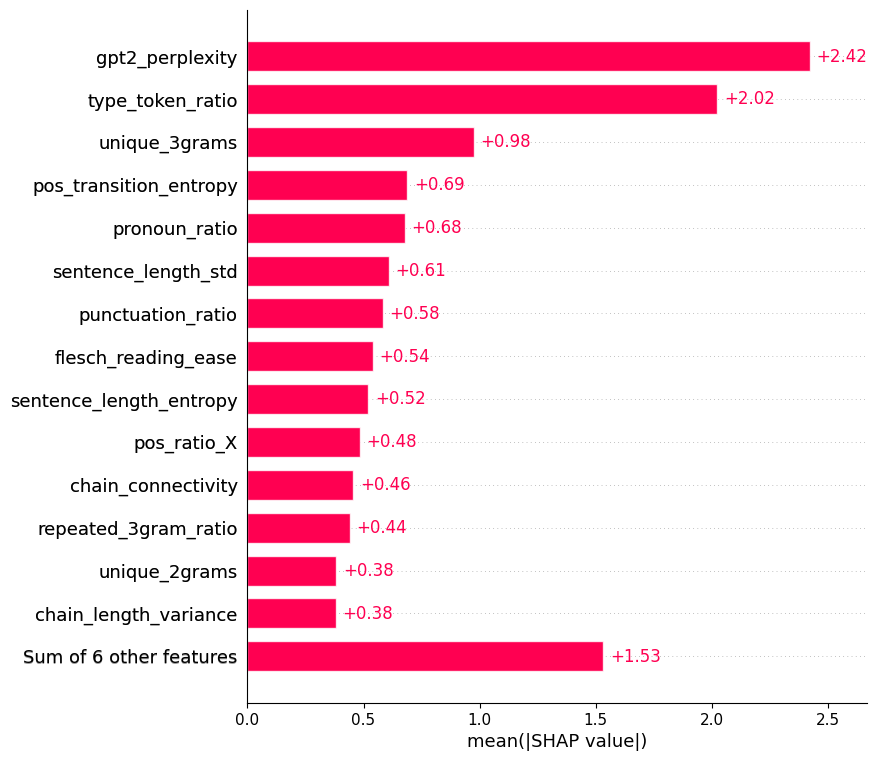


💡 Recommendation: 🟢 STRONG: Add new features

Co-reference Resolution Features analysis complete!

DETAILED CO-REFERENCE FEATURE BREAKDOWN

🎯 CHAIN DIVERSITY ENTROPY
--------------------------------------------------
Basic Stats    : Mean=0.4002, Std=0.2684
Data Quality   : Non-zero=12777/16000 (79.9%)
Class Diff     : Human=0.3999, AI=0.4005, Diff=-0.0007
Significance   : p=0.8736 , Effect=-0.0025, Corr=0.0013
SHAP Impact    : 0.1509
Overall Rank   : #1

🎯 CHAIN LENGTH VARIANCE
--------------------------------------------------
Basic Stats    : Mean=6.9030, Std=79.5852
Data Quality   : Non-zero=15606/16000 (97.5%)
Class Diff     : Human=3.1879, AI=10.6180, Diff=-7.4300
Significance   : p=0.0000 ***, Effect=-0.0935, Corr=0.0467
SHAP Impact    : 0.2631
Overall Rank   : #2

🎯 LONG RANGE COREF RATIO
--------------------------------------------------
Basic Stats    : Mean=0.4233, Std=0.2875
Data Quality   : Non-zero=13232/16000 (82.7%)
Class Diff     : Human=0.4327, AI=0.4139, Diff=0.0189

In [ ]:
# Complete Co-reference Resolution Feature Analysis - Exact Format /// WITH FULL
from Analyse_feature import FeatureAnalyzer
from scipy import stats
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("🧬 CO-REFERENCE RESOLUTION FEATURE ANALYSIS")
print("=" * 80)

# Load dataset
print("📊 Loading dataset...")
df = pd.read_csv('train_ablation.csv')
print(f"✅ Dataset loaded: {df.shape}")

print("\n🔍 Extracting co-reference features...")
# Extract co-reference features using your working extractor
df_with_coref = extractor.extract_coref_features(df, text_column='generation')

# Setup analysis
analyzer = FeatureAnalyzer()

# Your working coreference features
coref_features = [
    'chain_diversity_entropy',
    'chain_length_variance',
    'long_range_coref_ratio',
    'mention_complexity',
    'singleton_ratio',
    'pronoun_ratio',
    'chain_connectivity',
    'avg_cluster_size'
]

# Filter to only features that exist and have data
existing_coref_features = []
for feature in coref_features:
    if feature in df_with_coref.columns:
        non_zero_count = (df_with_coref[feature] > 0).sum()
        if non_zero_count > 0:  # Only include features with some non-zero values
            existing_coref_features.append(feature)

print(f"📊 Available coreference features: {len(existing_coref_features)}")
print(f"🎯 Features: {existing_coref_features}")

# Get existing features for comparison
exclude_cols = set(existing_coref_features + ['binary_label_code', 'binary_label', 'generation', 'text', 'id', 'source_id', 'adv_source_id'])
existing_features = [col for col in df_with_coref.columns
                    if col not in exclude_cols and pd.api.types.is_numeric_dtype(df_with_coref[col])]

print(f"\n🎯 Analysis setup:")
print(f"Co-reference features: {existing_coref_features}")
print(f"Existing features for comparison: {len(existing_features)}")

# Run comprehensive analysis
print(f"\n📈 Running comprehensive analysis...")
results = analyzer.analyze_features(
    df=df_with_coref,
    feature_names=existing_coref_features,
    target_col='binary_label_code',
    feature_type_name="Co-reference Resolution Features",
    existing_features=existing_features if existing_features else None
)

# Extract results for detailed breakdown
stats_results = results['stats_results']
model_results = results['model_results']
shap_results = results['shap_results']
comparison_results = results['comparison_results']

# Feature-by-feature detailed breakdown
print(f"\n" + "="*80)
print("DETAILED CO-REFERENCE FEATURE BREAKDOWN")
print("="*80)

feature_analysis = {}
for feature in existing_coref_features:
    print(f"\n🎯 {feature.upper().replace('_', ' ')}")
    print("-" * 50)

    # Basic statistics
    feature_data = df_with_coref[feature]
    mean_val = feature_data.mean()
    std_val = feature_data.std()
    non_zero_count = (feature_data > 0).sum()
    zero_ratio = (feature_data == 0).sum() / len(feature_data)

    # Class comparison
    human_data = df_with_coref[df_with_coref['binary_label_code'] == 0][feature]
    ai_data = df_with_coref[df_with_coref['binary_label_code'] == 1][feature]
    human_mean = human_data.mean()
    ai_mean = ai_data.mean()
    difference = human_mean - ai_mean

    # Statistical tests
    t_stat, p_value = stats.ttest_ind(human_data, ai_data, equal_var=False)
    if (human_data.var() + ai_data.var()) > 0:
        effect_size = difference / np.sqrt((human_data.var() + ai_data.var()) / 2)
    else:
        effect_size = 0.0
    correlation = feature_data.corr(df_with_coref['binary_label_code'])

    # SHAP importance
    shap_importance = 0
    comparison_rank = "N/A"
    if shap_results and 'feature_importance' in shap_results:
        shap_importance = shap_results['feature_importance'].get(feature, 0)
    if comparison_results and 'importance_df' in comparison_results:
        importance_df = comparison_results['importance_df']
        if feature in importance_df['feature'].values:
            comparison_rank = importance_df[importance_df['feature'] == feature].index[0] + 1

    print(f"Basic Stats    : Mean={mean_val:.4f}, Std={std_val:.4f}")
    print(f"Data Quality   : Non-zero={non_zero_count}/{len(df_with_coref)} ({100*(1-zero_ratio):.1f}%)")
    print(f"Class Diff     : Human={human_mean:.4f}, AI={ai_mean:.4f}, Diff={difference:.4f}")
    print(f"Significance   : p={p_value:.4f} {'***' if p_value<0.001 else '**' if p_value<0.01 else '*' if p_value<0.05 else ''}, Effect={effect_size:.4f}, Corr={correlation:.4f}")
    print(f"SHAP Impact    : {shap_importance:.4f}")
    print(f"Overall Rank   : #{comparison_rank}")

    feature_analysis[feature] = {
        'p_value': p_value, 'effect_size': abs(effect_size), 'correlation': abs(correlation),
        'shap_importance': shap_importance, 'comparison_rank': comparison_rank if comparison_rank != "N/A" else 999,
        'mean_value': mean_val, 'class_difference': abs(difference), 'zero_ratio': zero_ratio,
        'data_quality': 1 - zero_ratio, 't_stat': t_stat,
        'human_mean': human_mean, 'ai_mean': ai_mean
    }

# Feature scoring and selection
print(f"\n" + "="*80)
print("CO-REFERENCE FEATURE INCLUSION DECISION")
print("="*80)

feature_scores = {}
for feature, data in feature_analysis.items():
    score = 0
    reasons = []

    # Statistical significance (higher weight)
    if data['p_value'] < 0.001:
        score += 5
        reasons.append("Highly significant (p<0.001)")
    elif data['p_value'] < 0.01:
        score += 4
        reasons.append("Very significant (p<0.01)")
    elif data['p_value'] < 0.05:
        score += 3
        reasons.append("Significant (p<0.05)")
    elif data['p_value'] < 0.1:
        score += 2
        reasons.append("Marginally significant (p<0.1)")

    # Effect size
    if data['effect_size'] > 0.8:
        score += 4
        reasons.append("Large effect")
    elif data['effect_size'] > 0.5:
        score += 3
        reasons.append("Medium effect")
    elif data['effect_size'] > 0.2:
        score += 2
        reasons.append("Small effect")
    elif data['effect_size'] > 0.1:
        score += 1
        reasons.append("Minimal effect")

    # Correlation strength
    if data['correlation'] > 0.3:
        score += 4
        reasons.append("Strong correlation")
    elif data['correlation'] > 0.2:
        score += 3
        reasons.append("Moderate correlation")
    elif data['correlation'] > 0.1:
        score += 2
        reasons.append("Weak correlation")
    elif data['correlation'] > 0.05:
        score += 1
        reasons.append("Very weak correlation")

    # SHAP importance
    if data['shap_importance'] > 0.5:
        score += 6
        reasons.append("Very high SHAP importance")
    elif data['shap_importance'] > 0.3:
        score += 4
        reasons.append("High SHAP importance")
    elif data['shap_importance'] > 0.2:
        score += 3
        reasons.append("Moderate SHAP importance")
    elif data['shap_importance'] > 0.1:
        score += 2
        reasons.append("Low SHAP importance")
    elif data['shap_importance'] > 0.05:
        score += 1
        reasons.append("Minimal SHAP importance")

    # Ranking bonus
    if data['comparison_rank'] <= 5:
        score += 4
        reasons.append(f"Top 5 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 10:
        score += 3
        reasons.append(f"Top 10 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 15:
        score += 2
        reasons.append(f"Top 15 rank (#{data['comparison_rank']})")
    elif data['comparison_rank'] <= 20:
        score += 1
        reasons.append(f"Top 20 rank (#{data['comparison_rank']})")

    # Data quality bonus
    if data['data_quality'] > 0.9:
        score += 3
        reasons.append("Excellent data quality")
    elif data['data_quality'] > 0.8:
        score += 2
        reasons.append("High data quality")
    elif data['data_quality'] > 0.6:
        score += 1
        reasons.append("Good data quality")
    elif data['data_quality'] < 0.3:
        score -= 2
        reasons.append("Poor data quality")

    # Practical significance
    if data['class_difference'] > 0.1:
        score += 2
        reasons.append("Large practical difference")
    elif data['class_difference'] > 0.05:
        score += 1
        reasons.append("Moderate practical difference")

    feature_scores[feature] = {'score': score, 'reasons': reasons}

# Display results
print(f"\n🏆 CO-REFERENCE FEATURE SCORING RESULTS:")
print(f"{'Feature':<25} {'Score':<6} {'Decision':<12} {'SHAP':<8} {'Rank':<6} {'Reasons'}")
print("-" * 100)

# Sort by SHAP importance first, then by score
shap_sorted_features = sorted(existing_coref_features,
                             key=lambda x: (feature_analysis[x]['shap_importance'],
                                          feature_scores[x]['score']), reverse=True)

recommended_features = []
for feature in shap_sorted_features:
    score = feature_scores[feature]['score']
    reasons = feature_scores[feature]['reasons']
    shap_val = feature_analysis[feature]['shap_importance']
    rank_val = feature_analysis[feature]['comparison_rank']

    # Decision logic
    if score >= 15:
        decision = "🟢 MUST INCLUDE"
        recommended_features.append(feature)
    elif score >= 10:
        decision = "✅ INCLUDE"
        recommended_features.append(feature)
    elif score >= 6:
        decision = "🟡 CONSIDER"
        if shap_val > 0.1 or feature_analysis[feature]['p_value'] < 0.05:
            recommended_features.append(feature)
    elif score >= 3:
        decision = "🟠 MAYBE"
        if shap_val > 0.2:
            recommended_features.append(feature)
    else:
        decision = "❌ EXCLUDE"

    reasons_str = ", ".join(reasons[:2]) + ("..." if len(reasons) > 2 else "")
    print(f"{feature:<25} {score:<6} {decision:<12} {shap_val:<8.3f} #{rank_val:<5} {reasons_str}")

# Final recommendation section
print(f"\n" + "="*80)
print("FINAL CO-REFERENCE FEATURE RECOMMENDATION")
print("="*80)

if comparison_results:
    improvement = comparison_results['improvement']
    print(f"📊 Overall Performance Impact: +{improvement:.4f} AUC improvement")

print(f"\n💡 RECOMMENDED CO-REFERENCE FEATURES TO INCLUDE:")

if recommended_features:
    for feature in recommended_features:
        score = feature_scores[feature]['score']
        rank = feature_analysis[feature]['comparison_rank']
        shap = feature_analysis[feature]['shap_importance']
        p_val = feature_analysis[feature]['p_value']
        quality = feature_analysis[feature]['data_quality']
        print(f"   ✅ {feature:<25} (Score: {score}/23, Rank: #{rank}, SHAP: {shap:.3f}, p: {p_val:.3f}, Quality: {quality:.3f})")

    print(f"\n📁 READY FOR INCLUSION:")
    print(f"   Co-reference features to add: {recommended_features}")

    print(f"\n📈 FEATURE PERFORMANCE:")
    for feature in recommended_features:
        human_vals = df_with_coref[df_with_coref['binary_label_code'] == 0][feature]
        ai_vals = df_with_coref[df_with_coref['binary_label_code'] == 1][feature]
        print(f"   • {feature}: Human μ={human_vals.mean():.4f}, AI μ={ai_vals.mean():.4f}")

    # Store results globally
    globals()['df_with_coref'] = df_with_coref
    globals()['coref_features_to_merge'] = recommended_features
    globals()['coref_analysis_results'] = results

    print(f"\n✅ SUCCESS: Co-reference features ready for integration!")
    print(f"📊 Enhanced DataFrame: 'df_with_coref' ({df_with_coref.shape})")
    print(f"🎯 Recommended features: 'coref_features_to_merge' ({len(recommended_features)} features)")

else:
    print(f"   ❌ NO CO-REFERENCE FEATURES MEET INCLUSION CRITERIA")
    print(f"📊 However, 'df_with_coref' contains all extracted features for manual review")

print(f"\n🏁 Co-reference analysis complete!")

# Optional: Save analysis summary
if len(existing_coref_features) > 0:
    analysis_summary = pd.DataFrame({
        'feature': list(feature_analysis.keys()),
        'score': [feature_scores[f]['score'] for f in feature_analysis.keys()],
        'p_value': [feature_analysis[f]['p_value'] for f in feature_analysis.keys()],
        'effect_size': [feature_analysis[f]['effect_size'] for f in feature_analysis.keys()],
        'shap_importance': [feature_analysis[f]['shap_importance'] for f in feature_analysis.keys()],
        'correlation': [feature_analysis[f]['correlation'] for f in feature_analysis.keys()],
        'data_quality': [feature_analysis[f]['data_quality'] for f in feature_analysis.keys()],
        'rank': [feature_analysis[f]['comparison_rank'] for f in feature_analysis.keys()],
        'recommended': [f in recommended_features for f in feature_analysis.keys()],
        'human_mean': [feature_analysis[f]['human_mean'] for f in feature_analysis.keys()],
        'ai_mean': [feature_analysis[f]['ai_mean'] for f in feature_analysis.keys()]
    })

    analysis_summary.to_csv('coreference_analysis_summary.csv', index=False)
    print(f"\n📁 Analysis summary saved to: coreference_analysis_summary.csv")

In [ ]:
df_with_coref[['binary_label', 'binary_label_code']].head()

,binary_label,binary_label_code
0,human,0
1,artificial,1
2,human,0
3,artificial,1
4,artificial,1


In [ ]:
# Read the aggregated DataFrame
aggregated_df = pd.read_csv('aggregated_df.csv')
print(f"📊 Loaded aggregated_df: {aggregated_df.shape}")
print(f"🔍 Existing columns: {len(aggregated_df.columns)}")

# Add chain_connectivity and pronoun_ratio to aggregated_df
features_to_add = [
    'chain_connectivity',
    'avg_cluster_size',
    'singleton_ratio',
    'chain_length_variance',
    'pronoun_ratio',
]

# Create a subset with just the features we want to add
feature_subset = df_with_coref[['id'] + features_to_add].copy()

# Merge with aggregated_df
aggregated_df = aggregated_df.merge(feature_subset, on='id', how='left')

print(f"\n✅ Added {features_to_add} to aggregated_df")
print(f"📊 New aggregated_df shape: {aggregated_df.shape}")
print(f"🔍 Added columns: {features_to_add}")

# Verify the merge worked
print(f"\n📈 Feature statistics in aggregated_df:")
for feature in features_to_add:
    non_null = aggregated_df[feature].notna().sum()
    print(f"   {feature}: {non_null}/{len(aggregated_df)} non-null values")

# Save the updated aggregated DataFrame
aggregated_df.to_csv('aggregated_df.csv', index=False)
print(f"\n💾 Saved updated aggregated_df.csv")


📊 Loaded aggregated_df: (16000, 2)
🔍 Existing columns: 2

✅ Added ['chain_connectivity', 'avg_cluster_size', 'singleton_ratio', 'chain_length_variance', 'pronoun_ratio'] to aggregated_df
📊 New aggregated_df shape: (16000, 7)
🔍 Added columns: ['chain_connectivity', 'avg_cluster_size', 'singleton_ratio', 'chain_length_variance', 'pronoun_ratio']

📈 Feature statistics in aggregated_df:
   chain_connectivity: 16000/16000 non-null values
   avg_cluster_size: 16000/16000 non-null values
   singleton_ratio: 16000/16000 non-null values
   chain_length_variance: 16000/16000 non-null values
   pronoun_ratio: 16000/16000 non-null values

💾 Saved updated aggregated_df.csv
